<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/NorthwesternHeader.png?raw=1">

## **MSDS453 - Research Assignment 02 - Classification and Clustering**

Clustering methods compute a similarity (or closeness) measure, such as Euclidean distance, in order to decide whether two documents are ‘similar’ or not.  

Use the entire class corpus and do sentiment analysis for the positive and negative reviews.

Topic modeling is another way to group ‘similar’ documents into ‘clusters’.

# **1. Modules and Loading Data Set via Google Drive**

In [1]:
import pandas as pd
import os
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import random
from dataclasses import dataclass

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

import gensim
from gensim import corpora, similarities
from gensim.models import Word2Vec, LdaMulticore, TfidfModel, CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import LsiModel,LdaModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE, MDS
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import MultinomialNB

import scipy.cluster.hierarchy

from IPython.display import display, HTML

from typing import List, Callable, Dict

### Mount Google Drive to Colab Environment

<div class="alert alert-block alert-success">
    <b>Directories Required for Research Assignment</b>:<br>
1. Data Directory - Source Class Corpus Data<br>
2. Output Directory - Vocabulary<br>
</div>

#### Uncomment To Map Google Drive

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive')

&nbsp;

# **2. NLTK Downloads, etc, Data Wrangling Utility Functions, and Loading the Corpus**

In [3]:
# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

<div class="alert alert-block alert-danger">
<b>Gensim</b> is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community <br><br>
    <b>https://pypi.org/project/gensim/ </b>
</div>

In [4]:
print("Genism Version: ", gensim.__version__)

Genism Version:  4.3.2


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [5]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Data Wrangling Utility Functions

In [6]:
# COMMENTED OUT FUNCTIONS HERE NOT REFERENCED BY OTHER PARTS OF NOTEBOOK

def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)

def get_corpus_df(path):
    data = pd.read_csv(path, encoding="utf-8")
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

@dataclass
class Document:
    doc_id: str
    text: str

# def normalize_document(document: Document) -> Document:
#     text = document.text
#     text = remove_punctuation(text)
#     text = lower_case(text)
#     text = remove_tags(text)
#     text = remove_special_chars_and_digits(text)

#     return Document(document.doc_id, text)

# def normalize_documents(documents: List[Document]) -> List[Document]:
#     """
#     Normalizes text for all given documents.
#     Removes punctuation, converts to lower case, removes tags and special characters.
#     """
#     return [normalize_document(x) for x in documents]

@dataclass
class TokenizedDocument:
    doc_id: str
    tokens: List[str]

# def tokenize_document(document: Document) -> TokenizedDocument:
#     tokens = nltk.word_tokenize(document.text)
#     return TokenizedDocument(document.doc_id, tokens)

# def tokenize_documents(documents: List[Document]) -> List[TokenizedDocument]:
#     return [tokenize_document(x) for x in documents]

# def lemmatize(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
#     result = []
#     lemmatizer = WordNetLemmatizer()
#     for document in documents:
#         output_tokens = [lemmatizer.lemmatize(w) for w in document.tokens]
#         result.append(TokenizedDocument(document.doc_id, output_tokens))
#
#     return result

# def stem(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
#     result = []
#     stemmer = PorterStemmer()
#     for document in documents:
#         output_tokens = [stemmer.stem(w) for w in document.tokens]
#         result.append(TokenizedDocument(document.doc_id, output_tokens))
#
#     return result

# def remove_stop_words(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
#     result = []
#
#     stop_words = set(nltk.corpus.stopwords.words('english'))
#     for document in documents:
#         filtered_tokens = [w for w in document.tokens if not w in stop_words]
#         result.append(TokenizedDocument(document.doc_id, filtered_tokens))
#
#     return result

# def add_flags(data: pd.DataFrame, casino_royale_doc_ids: List[int], action_doc_ids: List[int]):
#     data['is_casino_royale'] = data.index.isin(casino_royale_doc_ids)
#     data['is_action'] = data.index.isin(action_doc_ids)

# def get_all_tokens(documents: List[TokenizedDocument]) -> List[str]:
#     tokens = {y for x in documents for y in x.tokens}
#     return sorted(list(tokens))

def clean_doc(doc):
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    custom_stop_words = ['movies', 'movie', 'film', 'films', 'scene']
    stop_words.update(custom_stop_words)
    tokens = [w for w in tokens if not w in stop_words]
    # word stemming
    # ps=PorterStemmer()
    # tokens=[ps.stem(word) for word in tokens]
    return tokens

# def final_processed_text_disabled(doc):
#     #this is a function to join the processed text back
#     ' '.join(doc)
#     return doc

def tfidf(corpus, titles, ngram_range = (1,1)):
    #this is a function to created the tfidf matrix
    Tfidf=TfidfVectorizer(ngram_range=(1,1))

    #fit the vectorizer using final processed documents.  The vectorizer requires the
    #stiched back together document.

    TFIDF_matrix=Tfidf.fit_transform(corpus)

    #creating datafram from TFIDF Matrix

    # https://stackoverflow.com/questions/70215049/attributeerror-tfidfvectorizer-object-has-no-attribute-get-feature-names-out
    #words = Tfidf.get_feature_names() # For sklearn <= 0.24.x
    #matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)

    words = Tfidf.get_feature_names_out() # For sklearn >= 1.0.x
    matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names_out(), index=titles)
    return matrix #,words

def One_Hot(variable):
    #this is a function to one hot encode the classes
    LE=LabelEncoder()
    LE.fit(variable)
    Label1=LE.transform(variable)
    OHE=OneHotEncoder()
    labels=OHE.fit_transform(Label1.reshape(-1,1)).toarray()
    return labels

&nbsp;

# **3. Functions Latent Semantic Analysis, Latent Dirichlet Allocation, Word2Vec Matrix**
1. Latent Semantic Analysis
2. Latent Dirichlet Allocation
3. Word2Vec Matrix creation

In [7]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LSA model
    # train model
    lsamodel = LsiModel(doc_term_matrix
                        ,num_topics=number_of_topics
                        ,id2word = dictionary
                        ,power_iters=100)
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(lsamodel[doc_term_matrix])

    return lsamodel,dictionary,index

def lsa(tfidf_matrix, terms, n_components = 10):
    #this is a function to execute lsa.  inputs to the function include the tfidf matrix and
    #the desired number of components.

    LSA = TruncatedSVD(n_components=10)
    LSA.fit(tfidf_matrix)

    for i, comp in enumerate(LSA.components_):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
        print("Topic "+str(i)+": ")
        for t in sorted_terms:
            print(t[0])

def create_gensim_lda_model(doc_clean,number_of_topics,words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    ldamodel = LdaModel(doc_term_matrix
                        ,num_topics=number_of_topics
                        ,id2word = dictionary
                        ,alpha='auto'
                        ,eta='auto'
                        ,iterations=100
                        ,random_state=23
                        ,passes=20)
    # train model
    print(ldamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(ldamodel[doc_term_matrix])
    return ldamodel,dictionary,index,doc_term_matrix

def lda(tfidf_matrix, terms, topics = 3, num_words = 10):
    #this is a function to perform lda on the tfidf matrix.  function varibales include:
    #tfidf matrix, desired number of topic, and number of words per topic.

    topics = 3
    num_words = 10
    lda = LatentDirichletAllocation(n_components=topics).fit(tfidf_matrix)

    topic_dict = {}
    for topic_num, topic in enumerate(lda.components_):
        topic_dict[topic_num] = " ".join([terms[i]for i in topic.argsort()[:-num_words - 1:-1]])

    print(topic_dict)

def word2vec(processed_text, size = 100):
    #This is a function to generate the word2vec matrix. Input parameters include the
    #tokenized text and matrix size

    #word to vec
    model_w2v = Word2Vec(processed_text, vector_size=100, window=5, min_count=1, workers=4)

    #join all processed DSI words into single list
    processed_text_w2v=[]
    for i in processed_text:
        for k in i:
            processed_text_w2v.append(k)

    #obtian all the unique words from DSI
    w2v_words=list(set(processed_text_w2v))

    #can also use the get_feature_names() from TFIDF to get the list of words
    #w2v_words=Tfidf.get_feature_names()

    #empty dictionary to store words with vectors
    w2v_vectors={}

    #for loop to obtain weights for each word
    for i in w2v_words:
        temp_vec=model_w2v.wv[i]
        w2v_vectors[i]=temp_vec

    #create a final dataframe to view word vectors
    w2v_df=pd.DataFrame(w2v_vectors).transpose()
    print(w2v_df)
    return w2v_df

## This code below is Experimental#1 and Barry wants your feedback if this works or not

In [8]:
# # Experimental#1 code here will show you the movie titles for the topics
# # Uncomment all the code in this cell and it will override the above functions
# # Also switch ot the modified Experiment#1 code lines elsewhere to add the "titles" parameter
# # or you can ignore the commented lines for Experiment#1 code and continue your assignment.

# def create_gensim_lda_model(doc_clean,number_of_topics,words, titles):

#     dictionary = corpora.Dictionary(doc_clean)
#     doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
#     ldamodel = LdaModel(doc_term_matrix ,num_topics=number_of_topics,id2word = dictionary,alpha='auto',
#                                           eta='auto',iterations=100,random_state=23,passes=20)
#     print(ldamodel.print_topics(num_topics=number_of_topics, num_words=words))
#     index = similarities.MatrixSimilarity(ldamodel[doc_term_matrix])

#     # THIS CODE BELOW IS EXPERIMENTAL#1 AND BARRY WANTS YOUR FEEDBACK IF THIS WORKS OR NOT

#     # Method 1: Shows top 5 titles related to a topic; adjust the number accordingly.
#     for topic in ldamodel.print_topics(num_topics=number_of_topics, num_words=words):
#         topic_number = topic[0]
#         sims = index[ldamodel[doc_term_matrix[topic_number]]]
#         most_similar_titles = [titles[i[0]] for i in sorted(enumerate(sims), key=lambda item: -item[1])[:5]]
#         print('Most similar titles for topic #{}: {}'.format(topic_number, most_similar_titles))

#     # Method 2: Shows all titles sorted on most similar for each topic.
#     # Note you get all titles for all topics!

#     for document in doc_clean:
#         doc_bow = dictionary.doc2bow(document)
#         sims = index[ldamodel[doc_bow]]
#         most_similar_topic = sorted(enumerate(sims), key=lambda item: -item[1])[0][0]
#         #VERBOSE DEBUGGING: print('Document belongs to topic #{}'.format(most_similar_topic))

#     topic_titles = {}
#     for topic_number, topic in enumerate(ldamodel.print_topics(num_topics=number_of_topics, num_words=words)):
#         sims = index[ldamodel[doc_term_matrix[topic_number]]]
#         titles_for_topic = [titles[i[0]] for i in sorted(enumerate(sims), key=lambda item: -item[1])]
#         topic_titles[topic_number] = titles_for_topic
#         print('Titles for topic #{}: {}'.format(topic_number, titles_for_topic))

#     return ldamodel,dictionary,index,doc_term_matrix

# ##########

# def create_gensim_lsa_model(doc_clean, number_of_topics, words, titles):

#     dictionary = corpora.Dictionary(doc_clean)
#     doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

#     # generate LSA model
#     lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word=dictionary, power_iters=100)

#     print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
#     index = similarities.MatrixSimilarity(lsamodel[doc_term_matrix])

#     # THIS CODE BELOW IS EXPERIMENTAL AND BARRY WANTS YOUR FEEDBACK IF THIS WORKS OR NOT

#     # Method 1: Shows top 5 titles related to a topic; adjust the number accordingly.
#     for topic in lsamodel.print_topics(num_topics=number_of_topics, num_words=words):
#         topic_number = topic[0]
#         sims = index[lsamodel[doc_term_matrix[topic_number]]]
#         most_similar_titles = [titles[i[0]] for i in sorted(enumerate(sims), key=lambda item: -item[1])[:5]]
#         print('Most similar titles for topic #{}: {}'.format(topic_number, most_similar_titles))

#     # Method 2: Shows all titles sorted on most similar for each topic.
#     # Note you get all titles for all topics!

#     for document in doc_clean:
#         doc_bow = dictionary.doc2bow(document)
#         sims = index[lsamodel[doc_bow]]
#         most_similar_topic = sorted(enumerate(sims), key=lambda item: -item[1])[0][0]
#         #VERBOSE DEBUGGING: print('Document belongs to topic #{}'.format(most_similar_topic))

#     topic_titles = {}
#     for topic_number, topic in enumerate(lsamodel.print_topics(num_topics=number_of_topics, num_words=words)):
#         sims = index[lsamodel[doc_term_matrix[topic_number]]]
#         titles_for_topic = [titles[i[0]] for i in sorted(enumerate(sims), key=lambda item: -item[1])]
#         topic_titles[topic_number] = titles_for_topic
#         print('Titles for topic #{}: {}'.format(topic_number, titles_for_topic))

#     return lsamodel, dictionary, index

# ###########
# #
# # When you call create_gensim_lda_model(...) later on, you have to add titles to the call. Eg:
# #
# # model2,dictionary2,index2,doctermmatrix2=create_gensim_lda_model(processed_text,number_of_topics,words,titles)
# #
# # Similarly for LSA...

# **4. Modeling Functions: KMeans, SVM, Logistic, Naive Bayes, Randomforest**

In [9]:
def k_means(titles, tfidf_matrix, k=3):

    #this is a function to generate the k-means output using the tfidf matrix.  Inputs
    #to the function include: titles of text, processed text, and desired k value.
    #Returns dataframe indicating cluster number per document

    km = KMeans(n_clusters=k, random_state =89)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()

    Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
    frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])
    #dictionary to store clusters and respective titles
    cluster_title={}

    #note doc2vec clusters will not have individual words due to the vector representation
    #is based on the entire document not indvidual words. As a result, there won't be individual
    #word outputs from each cluster.
    for i in range(k):
        temp=frame[frame['Cluster']==i]
        temp_title_list=[]
        for title in temp['Doc Name']:
            temp_title_list.append(title)
        cluster_title[i]=temp_title_list

    # How to see the results of the k-means clustering
    #print ("cluster_title", cluster_title)
    #print ("clusters", clusters)
    #print ("frame", frame)
    return cluster_title,clusters,frame

def classifiers(x, y, model_type, cv = 3):

    #this function is to fit 3 different model scenarios.  Support vector machines, logistic regressions, naive bayes.
    #svm = Support vector machin
    #logistic = Logistic regression
    #naive_bayes = Naive Bayes Multinomial

    #can define cv value for cross validation.

    #function returns the train test split scores of each model.

    if model_type == 'svm':
        print("svm")
        model = SVC()

    elif model_type == 'logistic':
        print("logistic")
        model = LogisticRegression()

    elif model_type == 'naive_bayes':
        print("naive_bayes")
        model = MultinomialNB()

    elif model_type == 'randomforest':
        print("randomforest")
        model = RandomForestClassifier()

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=23)
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    accy = accuracy_score(y_test, predictions)
    return accy

## Visualization Utility Functions

In [10]:
def plot_lsa(number_of_topics, words):

    # BARRYC experimental#1
    #model,dictionary,index=create_gensim_lsa_model(processed_text,number_of_topics,words,titles)
    model,dictionary,index=create_gensim_lsa_model(processed_text,number_of_topics,words)

    for doc in processed_text:
        vec_bow = dictionary.doc2bow(doc)
        vec_lsi = model[vec_bow]  # convert the query to LSI space
        sims = index[vec_lsi] # perform a similarity query against the corpus

    fig, ax = plt.subplots(figsize=(30, 20))
    cax = ax.matshow(index, interpolation='nearest')
    ax.grid(True)
    plt.xticks(range(len(processed_text)), titles, rotation=90, fontsize=8);
    plt.yticks(range(len(processed_text)), titles, fontsize=8);
    fig.colorbar(cax)
    plt.show()
    return model

def plot_tfidf_matrix(cluster_title,clusters,TFIDF_matrix):
    # convert two components as we're plotting points in a two-dimensional plane
    # "precomputed" because we provide a distance matrix
    # we will also specify `random_state` so the plot is reproducible.

    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
    dist = 1 - cosine_similarity(TFIDF_matrix)
    pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
    xs, ys = pos[:, 0], pos[:, 1]


    #set up colors per clusters using a dict.  number of colors must correspond to K
    cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick',
                      5:'red', 6:'darksalmon', 7:'sienna'}

    #set up cluster names using a dict.
    cluster_dict=cluster_title

    #create data frame that has the result of the MDS plus the cluster numbers and titles
    df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters))))

    #group by cluster
    groups = df.groupby('label')

    fig, ax = plt.subplots(figsize=(20,20)) # set size
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    #iterate through groups to layer the plot
    #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
    for name, group in groups:

        r = random.random()
        b = random.random()
        g = random.random()
        color = (r, g, b)

        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
                label=cluster_dict[name], color=color,
                mec='none')
        ax.set_aspect('auto')
        ax.tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='on')
        ax.tick_params(\
            axis= 'y',         # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelleft='on')

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 30})      #show legend with only 1 point

## Loading the Class Corpus

In [11]:
CORPUS_PATH=\
'https://raw.githubusercontent.com/barrycforever/MSDS_453_Public/main/MSDS453_ClassCorpus/MSDS453_ClassCorpus_Final_Sec57_v2_20230928.csv'
data = get_corpus_df(CORPUS_PATH)

In [12]:
#adding two columns to the dataframe to store the processed text and tokenized text
data['processed_text'] = data['Text'].apply(lambda x: clean_doc(x))

#creating final processed text variables for matrix creation
final_processed_text = [' '.join(x) for x in data['processed_text'].tolist()]
titles = data['DSI_Title'].tolist()
processed_text = data['processed_text'].tolist()

1. Dataframe = corpus_df
2. List = documents (Document ID, Text)

&nbsp;

# **5. Exploratory Data Analysis**

In [13]:
CORPUS_PATH=\
'https://raw.githubusercontent.com/barrycforever/MSDS_453_Public/main/MSDS453_ClassCorpus/MSDS453_ClassCorpus_Final_Sec57_v2_20230928.csv'
corpus_df = get_corpus_df(CORPUS_PATH)
documents = [Document(x, y) for x, y in zip(corpus_df.Doc_ID, corpus_df.Text)]

In [14]:
corpus_df.shape

(200, 9)

In [15]:
corpus_df.head().T

Doc_ID                                                                   90  \
DSI_Title                                         LKP_Doc1_Angel_has_fallen   
Text                      Target is on the move . '' Heavily outnumbered...   
Submission File Name                              LKP_Doc1_Angel_has_fallen   
Student Name                                                            LKP   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel_has_fallen   
Descriptor                                     Action_Angel_has_fallen_N_90   
Doc_ID                                                                   90   

Doc_ID                                                                   91  \
DSI_Title                                         LKP_Doc2_Angel_has_fallen   
Text                      The sleepy , dopey action bonanza `` Angel Has...   
Submission File Name                              LKP_Doc2_Angel_has_fallen   
Student Name                                                            LKP   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel_has_fallen   
Descriptor                                     Action_Angel_has_fallen_N_91   
Doc_ID                                                                   91   

Doc_ID                                                                   92  \
DSI_Title                                         LKP_Doc3_Angel_has_fallen   
Text                      `` Angel Has Fallen '' marks the third time th...   
Submission File Name                              LKP_Doc3_Angel_has_fallen   
Student Name                                                            LKP   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel_has_fallen   
Descriptor                                     Action_Angel_has_fallen_N_92   
Doc_ID                                                                   92   

Doc_ID                                                                   93  \
DSI_Title                                         LKP_Doc4_Angel_has_fallen   
Text                      Improving through blandness . So Mike Banning ...   
Submission File Name                              LKP_Doc4_Angel_has_fallen   
Student Name                                                            LKP   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel_has_fallen   
Descriptor                                     Action_Angel_has_fallen_N_93   
Doc_ID                                                                   93   

Doc_ID                                                                   94  
DSI_Title                                         LKP_Doc5_Angel_has_fallen  
Text                      This review may contain spoilers . Angel Has F...  
Submission File Name                              LKP_Doc5_Angel_has_fallen  
Student Name                                                            LKP  
Genre of Movie                                                       Action  
Review Type (pos or neg)                                           Negative  
Movie Title                                                Angel_has_fallen  
Descriptor                                     Action_Angel_has_fallen_N_94  
Doc_ID                                                                   94

In [16]:
print(corpus_df.info());

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 90 to 164
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   DSI_Title                 200 non-null    object
 1   Text                      200 non-null    object
 2   Submission File Name      200 non-null    object
 3   Student Name              200 non-null    object
 4   Genre of Movie            200 non-null    object
 5   Review Type (pos or neg)  200 non-null    object
 6   Movie Title               200 non-null    object
 7   Descriptor                200 non-null    object
 8   Doc_ID                    200 non-null    int64 
dtypes: int64(1), object(8)
memory usage: 15.6+ KB
None


In [17]:
print(corpus_df['Movie Title'].unique())

['Angel_has_fallen' 'Inception' 'No_Time_to_Die' 'Taken' 'Taxi' 'Barbie'
 'Dirty_Grandpa' 'Holmes_and_Watson' 'Lost City' 'Mean_Girls'
 'Drag_Me_To_Hell' 'Fresh' 'It_Chapter_Two' 'The Conjuring 2' 'The_Others'
 'EQUILIBRIUM' 'Minority_Report' 'Oblivion' 'Pitch_Black' 'The_Batman']


Exploring different numbers of...


> LSA: **2**, **6**, **20** concepts and **10** words<br>
> LDA: **2**, **6**, **20** topics and **10** words<br>

1.   *Model Complexity*
2.   *Model Interpretability*
3.   *Evaluation of Coherence*
4.   *Avoid Overfitting*
5.   *Practical Implications*
6.   *Computational Implications*


## Latent Semantic Analysis - Research Number of Topics and Number of Words

### Plotting 2 concepts and 10 words

[(0, '0.174*"would" + 0.170*"story" + 0.163*"action" + 0.151*"first" + 0.141*"world" + 0.139*"characters" + 0.135*"character" + 0.129*"years" + 0.127*"could" + 0.125*"still"'), (1, '-0.567*"holmes" + -0.384*"watson" + -0.273*"ferrell" + -0.240*"reilly" + -0.228*"sherlock" + -0.162*"comedy" + -0.124*"brothers" + -0.090*"jokes" + 0.088*"action" + -0.086*"moriarty"')]


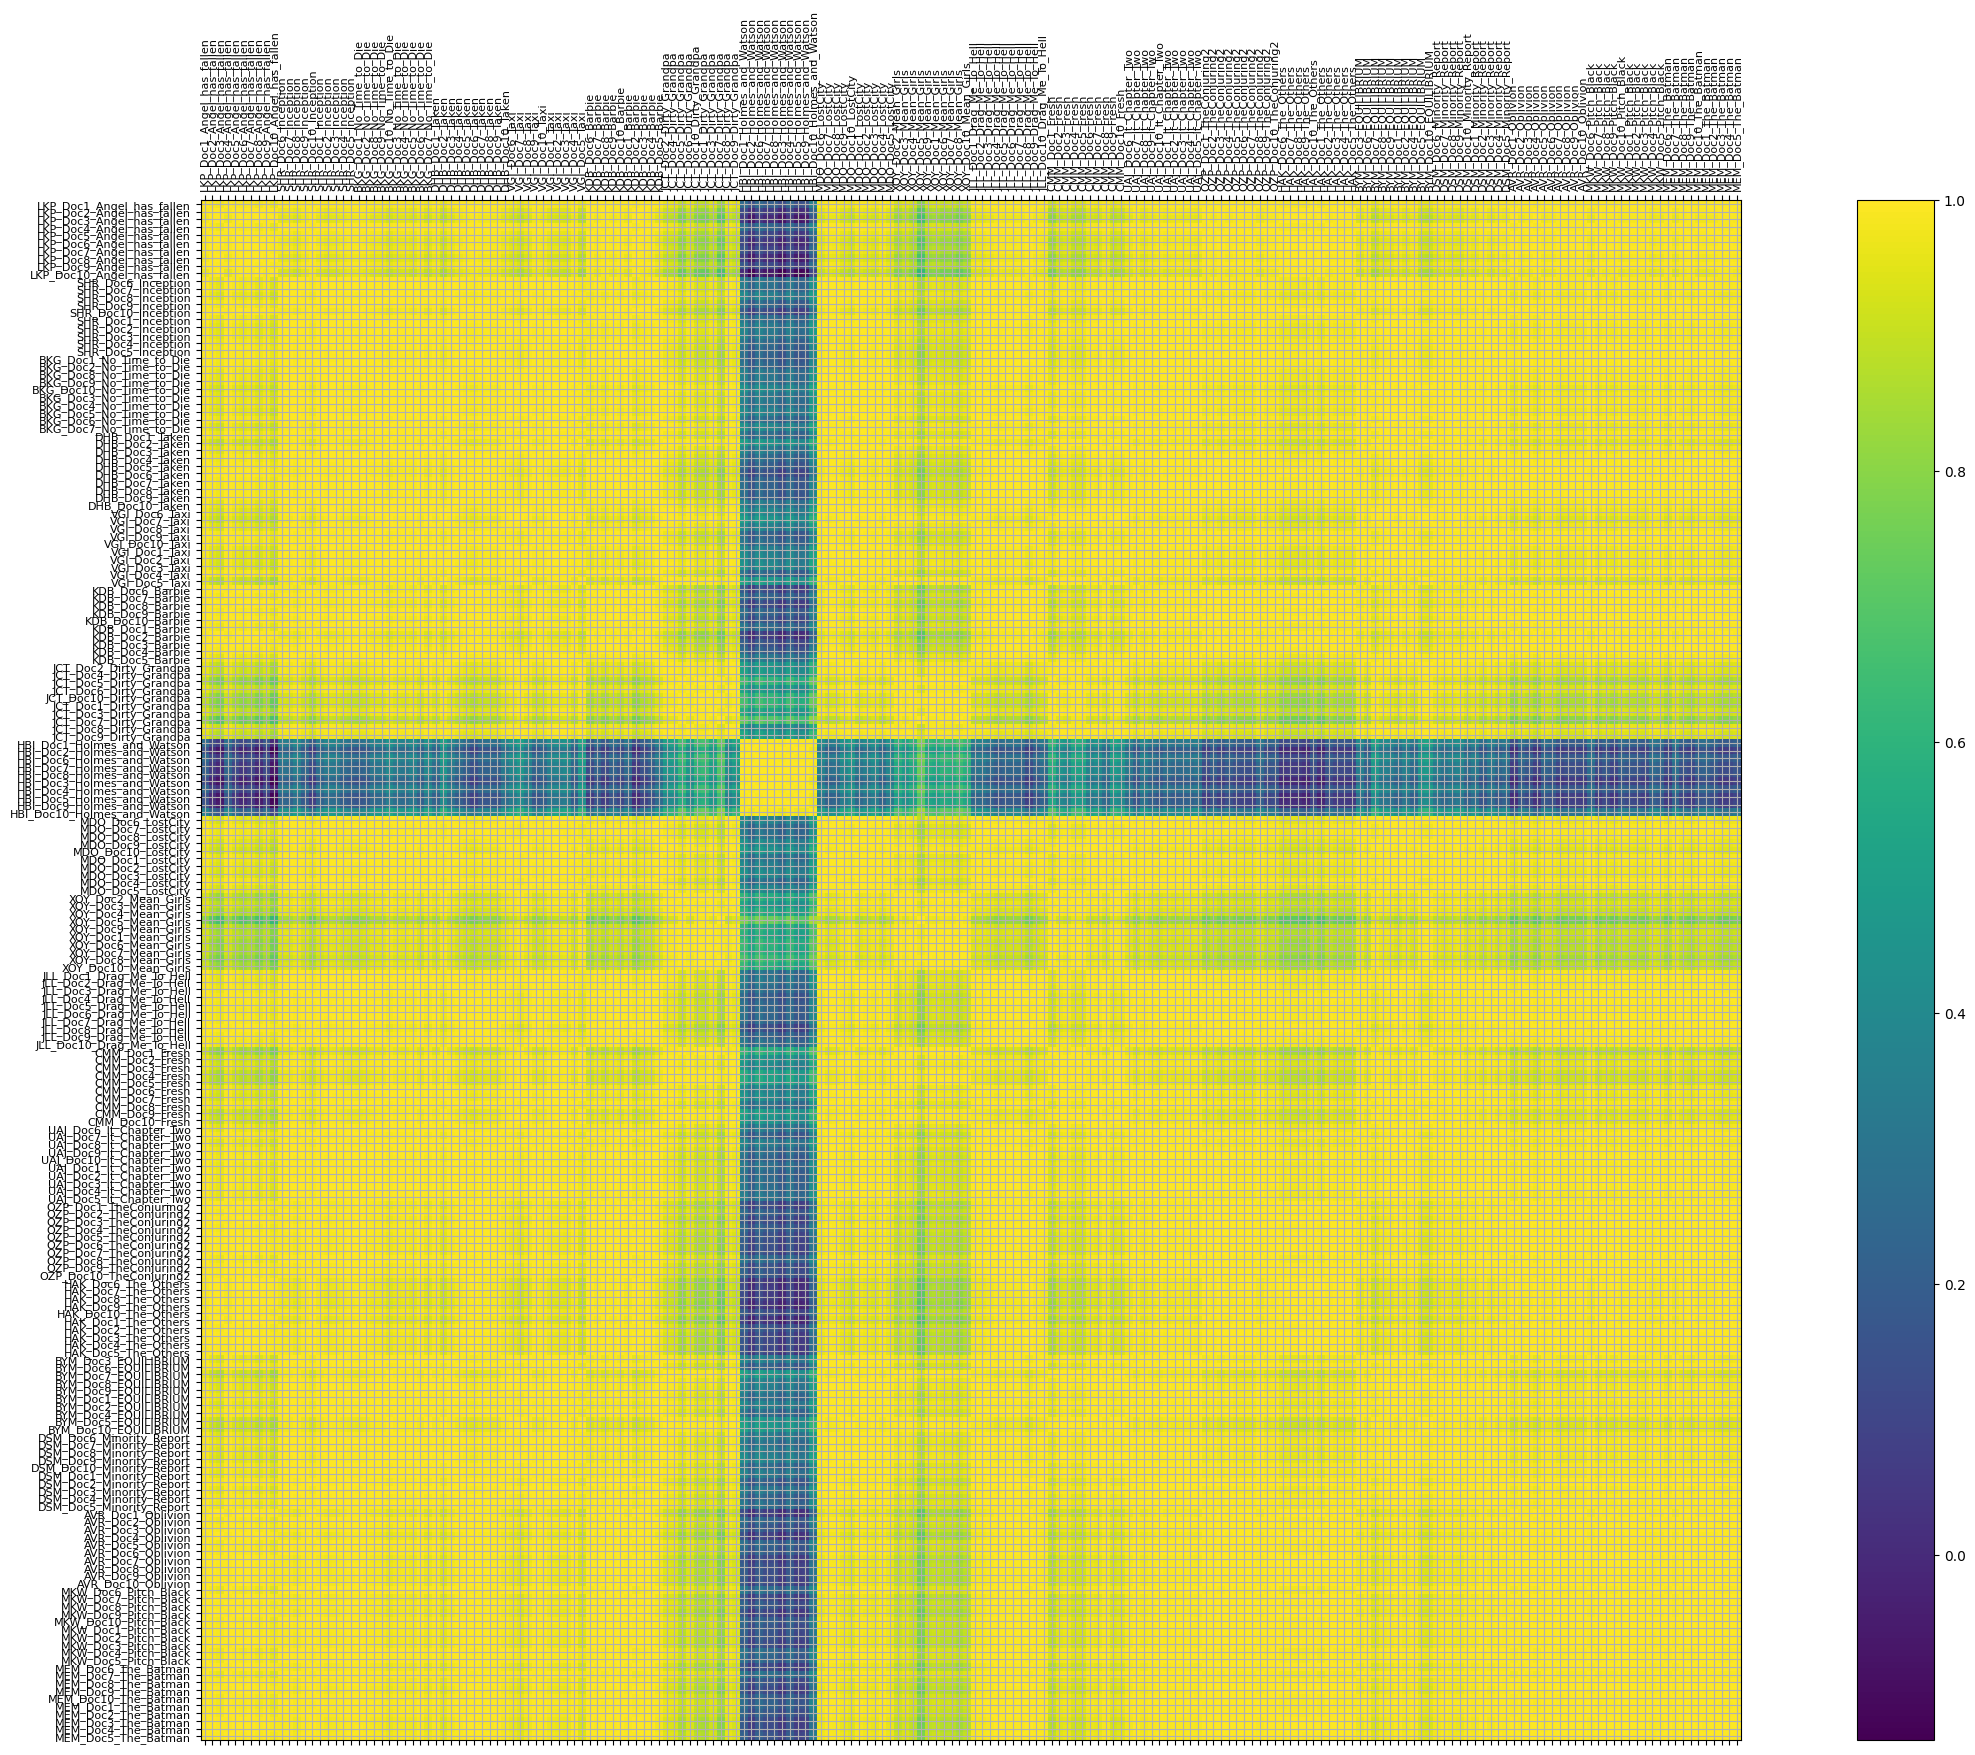

In [18]:
model_2concepts_10words=plot_lsa(2, 10)

### Plotting 4 concepts and 10 words

In [19]:
model_6concepts_10words=plot_lsa(4, 10)

Output hidden; open in https://colab.research.google.com to view.

### Plotting 20 concepts and 10 words

[(0, '-0.174*"would" + -0.170*"story" + -0.163*"action" + -0.151*"first" + -0.141*"world" + -0.139*"characters" + -0.135*"character" + -0.129*"years" + -0.127*"could" + -0.125*"still"'), (1, '0.567*"holmes" + 0.384*"watson" + 0.273*"ferrell" + 0.240*"reilly" + 0.228*"sherlock" + 0.162*"comedy" + 0.124*"brothers" + 0.090*"jokes" + -0.088*"action" + 0.086*"moriarty"'), (2, '-0.713*"barbie" + -0.167*"world" + -0.130*"girls" + -0.120*"school" + 0.119*"batman" + -0.115*"robbie" + -0.114*"women" + 0.092*"house" + -0.092*"daughter" + 0.091*"fallen"'), (3, '0.321*"fallen" + 0.255*"president" + -0.253*"house" + 0.235*"banning" + 0.226*"action" + 0.206*"angel" + -0.179*"horror" + -0.172*"grace" + -0.158*"children" + 0.126*"butler"'), (4, '0.450*"school" + 0.365*"girls" + -0.242*"barbie" + 0.177*"janis" + 0.167*"regina" + 0.158*"lohan" + -0.146*"batman" + 0.143*"plastics" + 0.128*"queen" + 0.117*"cliques"'), (5, '-0.439*"batman" + 0.233*"fallen" + 0.213*"house" + 0.199*"president" + 0.186*"bannin

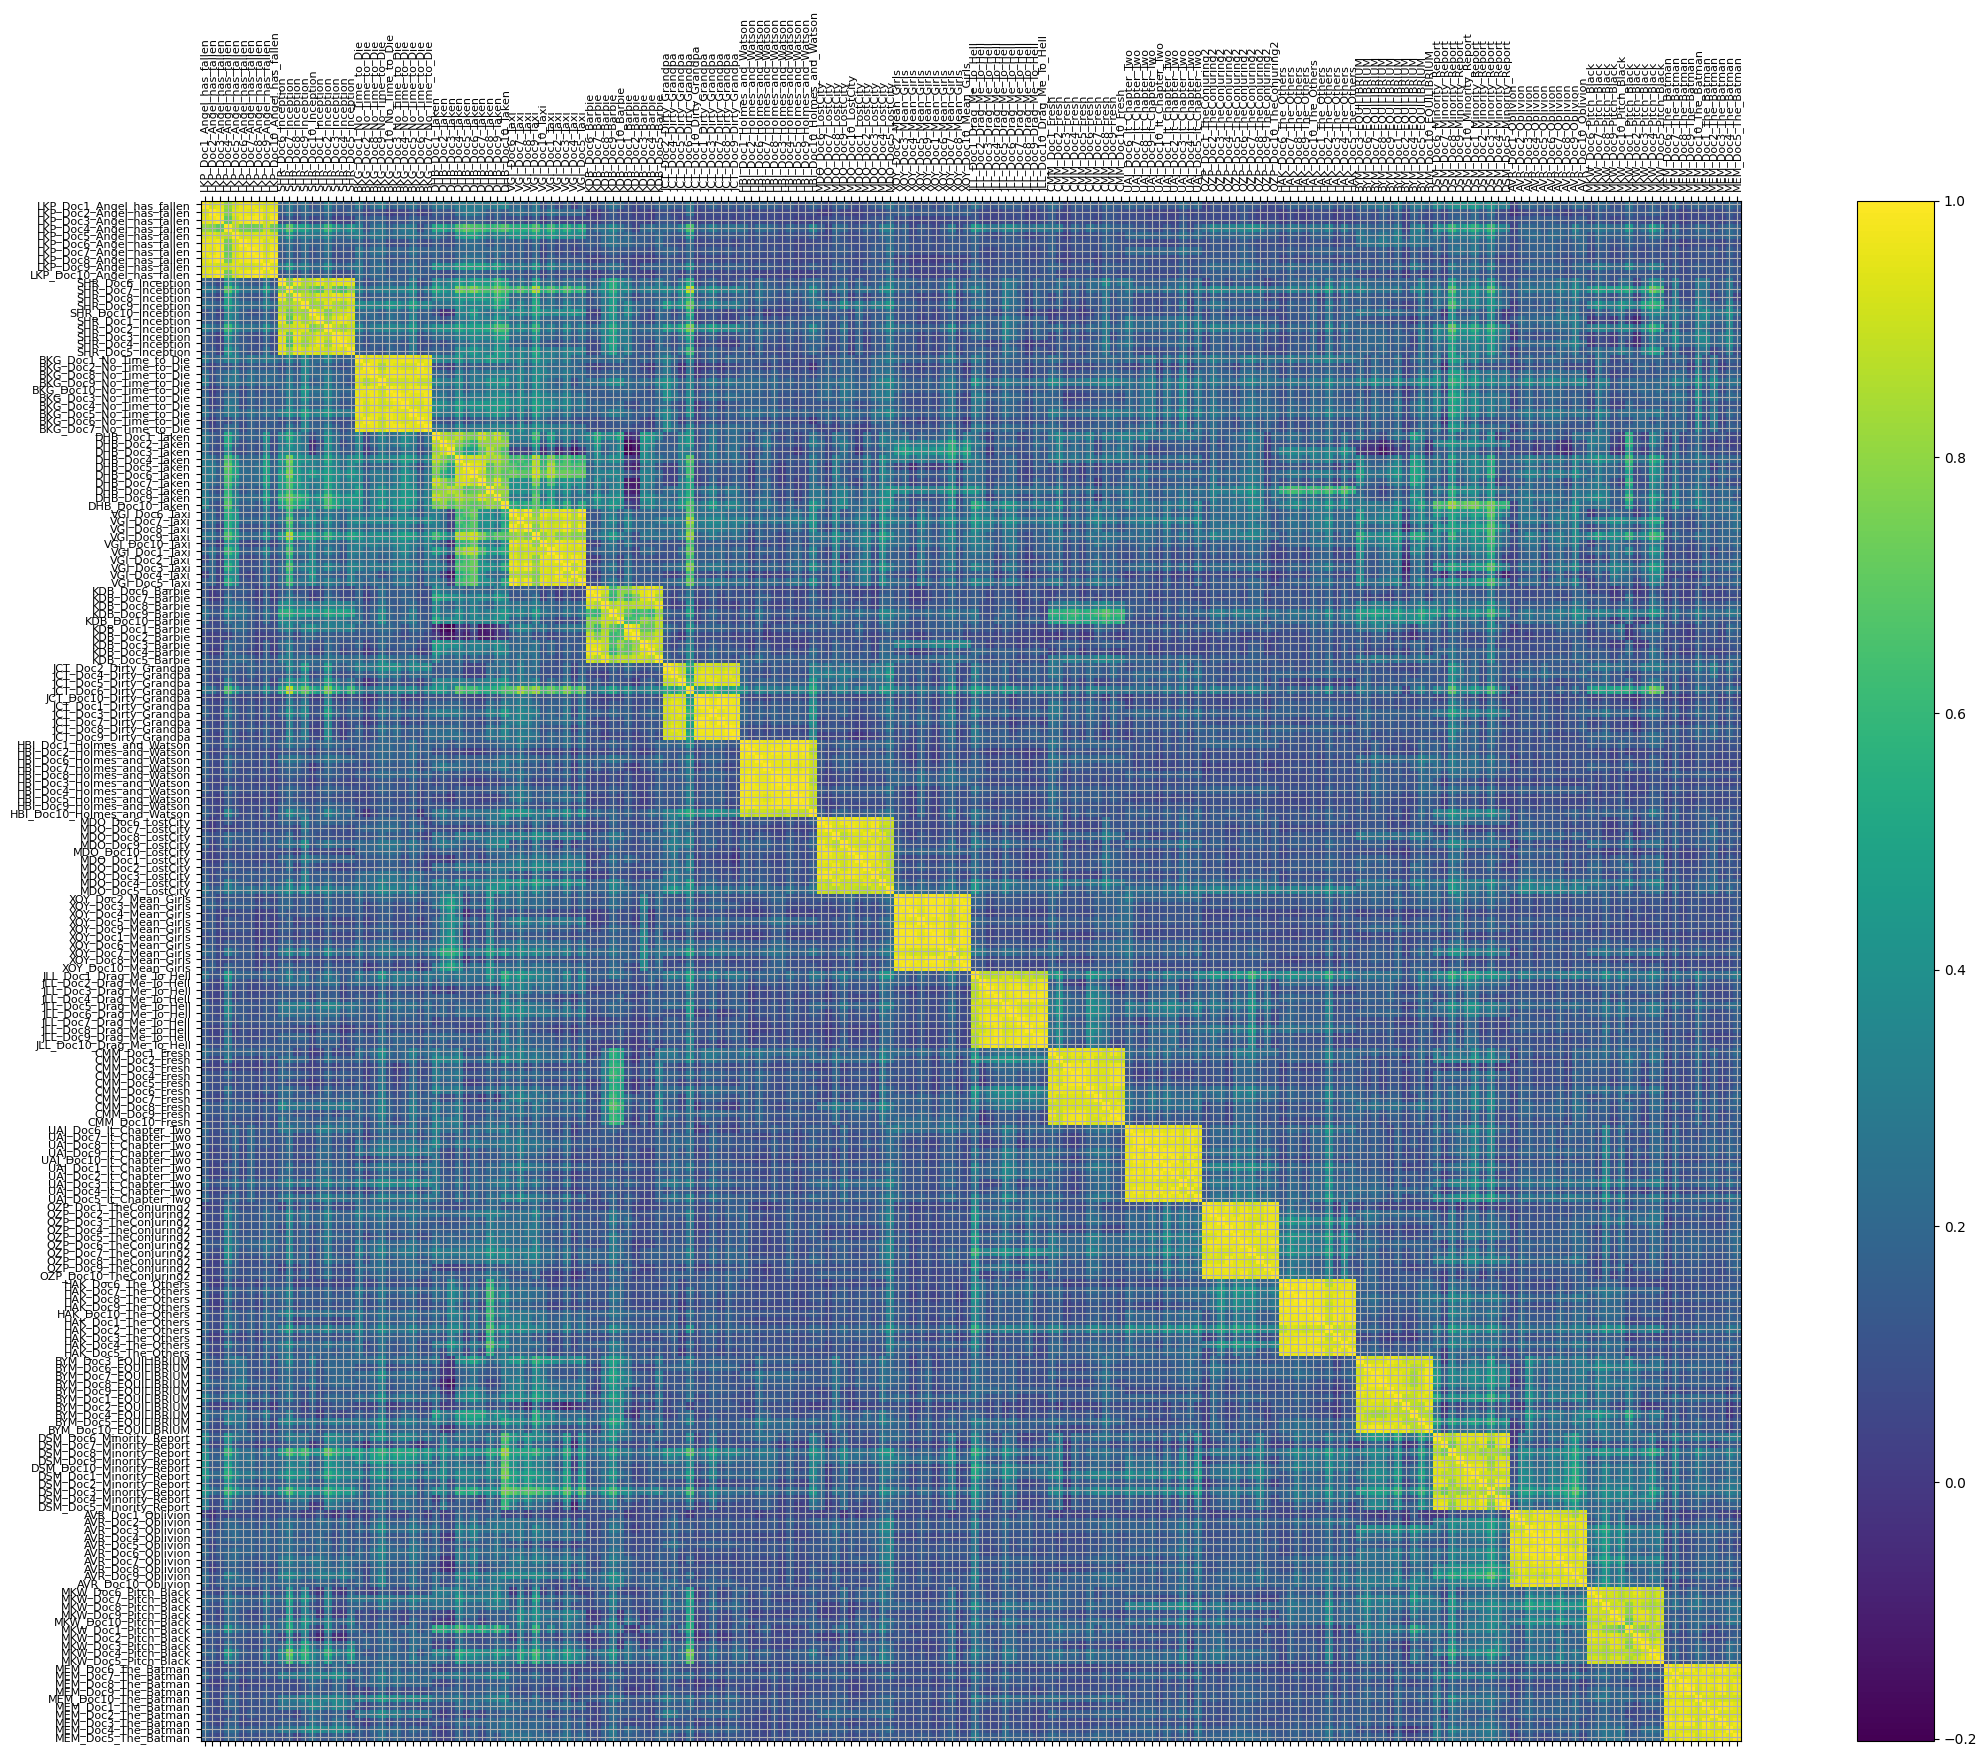

In [20]:
model_20concepts_10words=plot_lsa(20, 10)

### Compare LSA Model Coherence

In [21]:
topics = [i for i in range(2,20)]
coherence_values = []
for t in topics:
    #BARRYC EXPERIMENTAL#1
    # lsamodel,dictionary,index = create_gensim_lsa_model(processed_text,t,10, titles)
    lsamodel,dictionary,index = create_gensim_lsa_model(processed_text,t,10)


    coherence_model_lsa = CoherenceModel(model=lsamodel, dictionary=dictionary, texts=processed_text, coherence='c_v')
    coherence_lsa = coherence_model_lsa.get_coherence()
    coherence_values.append(coherence_lsa)


# coherence ={'4 concepts 10 words':coherence_values[0],
#            '2 concepts 10 words': coherence_values[1],
#            '20 concepts 10 words':coherence_values[2]}

coherence = {f"{i} concepts 10 words": coherence_values[i-2] for i in topics}

print(coherence)

[(0, '0.174*"would" + 0.170*"story" + 0.163*"action" + 0.151*"first" + 0.141*"world" + 0.139*"characters" + 0.135*"character" + 0.129*"years" + 0.127*"could" + 0.125*"still"'), (1, '0.567*"holmes" + 0.384*"watson" + 0.273*"ferrell" + 0.240*"reilly" + 0.228*"sherlock" + 0.162*"comedy" + 0.124*"brothers" + 0.090*"jokes" + -0.088*"action" + 0.086*"moriarty"')]


[(0, '0.174*"would" + 0.170*"story" + 0.163*"action" + 0.151*"first" + 0.141*"world" + 0.139*"characters" + 0.135*"character" + 0.129*"years" + 0.127*"could" + 0.125*"still"'), (1, '0.567*"holmes" + 0.384*"watson" + 0.273*"ferrell" + 0.240*"reilly" + 0.228*"sherlock" + 0.162*"comedy" + 0.124*"brothers" + 0.090*"jokes" + -0.088*"action" + 0.086*"moriarty"'), (2, '0.713*"barbie" + 0.167*"world" + 0.130*"girls" + 0.120*"school" + -0.119*"batman" + 0.115*"robbie" + 0.114*"women" + -0.092*"house" + 0.092*"daughter" + -0.091*"fallen"')]


[(0, '0.174*"would" + 0.170*"story" + 0.163*"action" + 0.151*"first" + 0.141*"world" + 0.139*"characters" + 0.135*"character" + 0.129*"years" + 0.127*"could" + 0.125*"still"'), (1, '-0.567*"holmes" + -0.384*"watson" + -0.273*"ferrell" + -0.240*"reilly" + -0.228*"sherlock" + -0.162*"comedy" + -0.124*"brothers" + -0.090*"jokes" + 0.088*"action" + -0.086*"moriarty"'), (2, '0.713*"barbie" + 0.167*"world" + 0.130*"girls" + 0.120*"school" + -0.119*"batman" + 0.115*"robbie" + 0.114*"women" + -0.092*"house" + 0.092*"daughter" + -0.091*"fallen"'), (3, '0.321*"fallen" + 0.255*"president" + -0.253*"house" + 0.235*"banning" + 0.226*"action" + 0.206*"angel" + -0.179*"horror" + -0.172*"grace" + -0.158*"children" + 0.126*"butler"')]


[(0, '0.174*"would" + 0.170*"story" + 0.163*"action" + 0.151*"first" + 0.141*"world" + 0.139*"characters" + 0.135*"character" + 0.129*"years" + 0.127*"could" + 0.125*"still"'), (1, '0.567*"holmes" + 0.384*"watson" + 0.273*"ferrell" + 0.240*"reilly" + 0.228*"sherlock" + 0.162*"comedy" + 0.124*"brothers" + 0.090*"jokes" + -0.088*"action" + 0.086*"moriarty"'), (2, '0.713*"barbie" + 0.167*"world" + 0.130*"girls" + 0.120*"school" + -0.119*"batman" + 0.115*"robbie" + 0.114*"women" + -0.092*"house" + 0.092*"daughter" + -0.091*"fallen"'), (3, '0.321*"fallen" + 0.255*"president" + -0.253*"house" + 0.235*"banning" + 0.226*"action" + 0.206*"angel" + -0.179*"horror" + -0.172*"grace" + -0.158*"children" + 0.126*"butler"'), (4, '-0.450*"school" + -0.365*"girls" + 0.242*"barbie" + -0.177*"janis" + -0.167*"regina" + -0.158*"lohan" + 0.146*"batman" + -0.143*"plastics" + -0.128*"queen" + -0.117*"cliques"')]


[(0, '0.174*"would" + 0.170*"story" + 0.163*"action" + 0.151*"first" + 0.141*"world" + 0.139*"characters" + 0.135*"character" + 0.129*"years" + 0.127*"could" + 0.125*"still"'), (1, '-0.567*"holmes" + -0.384*"watson" + -0.273*"ferrell" + -0.240*"reilly" + -0.228*"sherlock" + -0.162*"comedy" + -0.124*"brothers" + -0.090*"jokes" + 0.088*"action" + -0.086*"moriarty"'), (2, '-0.713*"barbie" + -0.167*"world" + -0.130*"girls" + -0.120*"school" + 0.119*"batman" + -0.115*"robbie" + -0.114*"women" + 0.092*"house" + -0.092*"daughter" + 0.091*"fallen"'), (3, '0.321*"fallen" + 0.255*"president" + -0.253*"house" + 0.235*"banning" + 0.226*"action" + 0.206*"angel" + -0.179*"horror" + -0.172*"grace" + -0.158*"children" + 0.126*"butler"'), (4, '-0.450*"school" + -0.365*"girls" + 0.242*"barbie" + -0.177*"janis" + -0.167*"regina" + -0.158*"lohan" + 0.146*"batman" + -0.143*"plastics" + -0.128*"queen" + -0.117*"cliques"'), (5, '0.439*"batman" + -0.233*"fallen" + -0.213*"house" + -0.199*"president" + -0.186*

[(0, '0.174*"would" + 0.170*"story" + 0.163*"action" + 0.151*"first" + 0.141*"world" + 0.139*"characters" + 0.135*"character" + 0.129*"years" + 0.127*"could" + 0.125*"still"'), (1, '0.567*"holmes" + 0.384*"watson" + 0.273*"ferrell" + 0.240*"reilly" + 0.228*"sherlock" + 0.162*"comedy" + 0.124*"brothers" + 0.090*"jokes" + -0.088*"action" + 0.086*"moriarty"'), (2, '-0.713*"barbie" + -0.167*"world" + -0.130*"girls" + -0.120*"school" + 0.119*"batman" + -0.115*"robbie" + -0.114*"women" + 0.092*"house" + -0.092*"daughter" + 0.091*"fallen"'), (3, '-0.321*"fallen" + -0.255*"president" + 0.253*"house" + -0.235*"banning" + -0.226*"action" + -0.206*"angel" + 0.179*"horror" + 0.172*"grace" + 0.158*"children" + -0.126*"butler"'), (4, '0.450*"school" + 0.365*"girls" + -0.242*"barbie" + 0.177*"janis" + 0.167*"regina" + 0.158*"lohan" + -0.146*"batman" + 0.143*"plastics" + 0.128*"queen" + 0.117*"cliques"'), (5, '0.439*"batman" + -0.233*"fallen" + -0.213*"house" + -0.199*"president" + -0.186*"banning" + 

[(0, '0.174*"would" + 0.170*"story" + 0.163*"action" + 0.151*"first" + 0.141*"world" + 0.139*"characters" + 0.135*"character" + 0.129*"years" + 0.127*"could" + 0.125*"still"'), (1, '-0.567*"holmes" + -0.384*"watson" + -0.273*"ferrell" + -0.240*"reilly" + -0.228*"sherlock" + -0.162*"comedy" + -0.124*"brothers" + -0.090*"jokes" + 0.088*"action" + -0.086*"moriarty"'), (2, '0.713*"barbie" + 0.167*"world" + 0.130*"girls" + 0.120*"school" + -0.119*"batman" + 0.115*"robbie" + 0.114*"women" + -0.092*"house" + 0.092*"daughter" + -0.091*"fallen"'), (3, '-0.321*"fallen" + -0.255*"president" + 0.253*"house" + -0.235*"banning" + -0.226*"action" + -0.206*"angel" + 0.179*"horror" + 0.172*"grace" + 0.158*"children" + -0.126*"butler"'), (4, '0.450*"school" + 0.365*"girls" + -0.242*"barbie" + 0.177*"janis" + 0.167*"regina" + 0.158*"lohan" + -0.146*"batman" + 0.143*"plastics" + 0.128*"queen" + 0.117*"cliques"'), (5, '0.439*"batman" + -0.233*"fallen" + -0.213*"house" + -0.199*"president" + -0.186*"banning

[(0, '0.174*"would" + 0.170*"story" + 0.163*"action" + 0.151*"first" + 0.141*"world" + 0.139*"characters" + 0.135*"character" + 0.129*"years" + 0.127*"could" + 0.125*"still"'), (1, '-0.567*"holmes" + -0.384*"watson" + -0.273*"ferrell" + -0.240*"reilly" + -0.228*"sherlock" + -0.162*"comedy" + -0.124*"brothers" + -0.090*"jokes" + 0.088*"action" + -0.086*"moriarty"'), (2, '0.713*"barbie" + 0.167*"world" + 0.130*"girls" + 0.120*"school" + -0.119*"batman" + 0.115*"robbie" + 0.114*"women" + -0.092*"house" + 0.092*"daughter" + -0.091*"fallen"'), (3, '-0.321*"fallen" + -0.255*"president" + 0.253*"house" + -0.235*"banning" + -0.226*"action" + -0.206*"angel" + 0.179*"horror" + 0.172*"grace" + 0.158*"children" + -0.126*"butler"'), (4, '-0.450*"school" + -0.365*"girls" + 0.242*"barbie" + -0.177*"janis" + -0.167*"regina" + -0.158*"lohan" + 0.146*"batman" + -0.143*"plastics" + -0.128*"queen" + -0.117*"cliques"'), (5, '-0.439*"batman" + 0.233*"fallen" + 0.213*"house" + 0.199*"president" + 0.186*"bann

[(0, '-0.174*"would" + -0.170*"story" + -0.163*"action" + -0.151*"first" + -0.141*"world" + -0.139*"characters" + -0.135*"character" + -0.129*"years" + -0.127*"could" + -0.125*"still"'), (1, '-0.567*"holmes" + -0.384*"watson" + -0.273*"ferrell" + -0.240*"reilly" + -0.228*"sherlock" + -0.162*"comedy" + -0.124*"brothers" + -0.090*"jokes" + 0.088*"action" + -0.086*"moriarty"'), (2, '-0.713*"barbie" + -0.167*"world" + -0.130*"girls" + -0.120*"school" + 0.119*"batman" + -0.115*"robbie" + -0.114*"women" + 0.092*"house" + -0.092*"daughter" + 0.091*"fallen"'), (3, '-0.321*"fallen" + -0.255*"president" + 0.253*"house" + -0.235*"banning" + -0.226*"action" + -0.206*"angel" + 0.179*"horror" + 0.172*"grace" + 0.158*"children" + -0.126*"butler"'), (4, '0.450*"school" + 0.365*"girls" + -0.242*"barbie" + 0.177*"janis" + 0.167*"regina" + 0.158*"lohan" + -0.146*"batman" + 0.143*"plastics" + 0.128*"queen" + 0.117*"cliques"'), (5, '-0.439*"batman" + 0.233*"fallen" + 0.213*"house" + 0.199*"president" + 0.1

[(0, '-0.174*"would" + -0.170*"story" + -0.163*"action" + -0.151*"first" + -0.141*"world" + -0.139*"characters" + -0.135*"character" + -0.129*"years" + -0.127*"could" + -0.125*"still"'), (1, '0.567*"holmes" + 0.384*"watson" + 0.273*"ferrell" + 0.240*"reilly" + 0.228*"sherlock" + 0.162*"comedy" + 0.124*"brothers" + 0.090*"jokes" + -0.088*"action" + 0.086*"moriarty"'), (2, '0.713*"barbie" + 0.167*"world" + 0.130*"girls" + 0.120*"school" + -0.119*"batman" + 0.115*"robbie" + 0.114*"women" + -0.092*"house" + 0.092*"daughter" + -0.091*"fallen"'), (3, '-0.321*"fallen" + -0.255*"president" + 0.253*"house" + -0.235*"banning" + -0.226*"action" + -0.206*"angel" + 0.179*"horror" + 0.172*"grace" + 0.158*"children" + -0.126*"butler"'), (4, '0.450*"school" + 0.365*"girls" + -0.242*"barbie" + 0.177*"janis" + 0.167*"regina" + 0.158*"lohan" + -0.146*"batman" + 0.143*"plastics" + 0.128*"queen" + 0.117*"cliques"'), (5, '0.439*"batman" + -0.233*"fallen" + -0.213*"house" + -0.199*"president" + -0.186*"banni

[(0, '-0.174*"would" + -0.170*"story" + -0.163*"action" + -0.151*"first" + -0.141*"world" + -0.139*"characters" + -0.135*"character" + -0.129*"years" + -0.127*"could" + -0.125*"still"'), (1, '0.567*"holmes" + 0.384*"watson" + 0.273*"ferrell" + 0.240*"reilly" + 0.228*"sherlock" + 0.162*"comedy" + 0.124*"brothers" + 0.090*"jokes" + -0.088*"action" + 0.086*"moriarty"'), (2, '-0.713*"barbie" + -0.167*"world" + -0.130*"girls" + -0.120*"school" + 0.119*"batman" + -0.115*"robbie" + -0.114*"women" + 0.092*"house" + -0.092*"daughter" + 0.091*"fallen"'), (3, '0.321*"fallen" + 0.255*"president" + -0.253*"house" + 0.235*"banning" + 0.226*"action" + 0.206*"angel" + -0.179*"horror" + -0.172*"grace" + -0.158*"children" + 0.126*"butler"'), (4, '-0.450*"school" + -0.365*"girls" + 0.242*"barbie" + -0.177*"janis" + -0.167*"regina" + -0.158*"lohan" + 0.146*"batman" + -0.143*"plastics" + -0.128*"queen" + -0.117*"cliques"'), (5, '-0.439*"batman" + 0.233*"fallen" + 0.213*"house" + 0.199*"president" + 0.186*"

[(0, '-0.174*"would" + -0.170*"story" + -0.163*"action" + -0.151*"first" + -0.141*"world" + -0.139*"characters" + -0.135*"character" + -0.129*"years" + -0.127*"could" + -0.125*"still"'), (1, '-0.567*"holmes" + -0.384*"watson" + -0.273*"ferrell" + -0.240*"reilly" + -0.228*"sherlock" + -0.162*"comedy" + -0.124*"brothers" + -0.090*"jokes" + 0.088*"action" + -0.086*"moriarty"'), (2, '0.713*"barbie" + 0.167*"world" + 0.130*"girls" + 0.120*"school" + -0.119*"batman" + 0.115*"robbie" + 0.114*"women" + -0.092*"house" + 0.092*"daughter" + -0.091*"fallen"'), (3, '0.321*"fallen" + 0.255*"president" + -0.253*"house" + 0.235*"banning" + 0.226*"action" + 0.206*"angel" + -0.179*"horror" + -0.172*"grace" + -0.158*"children" + 0.126*"butler"'), (4, '0.450*"school" + 0.365*"girls" + -0.242*"barbie" + 0.177*"janis" + 0.167*"regina" + 0.158*"lohan" + -0.146*"batman" + 0.143*"plastics" + 0.128*"queen" + 0.117*"cliques"'), (5, '0.439*"batman" + -0.233*"fallen" + -0.213*"house" + -0.199*"president" + -0.186*

[(0, '-0.174*"would" + -0.170*"story" + -0.163*"action" + -0.151*"first" + -0.141*"world" + -0.139*"characters" + -0.135*"character" + -0.129*"years" + -0.127*"could" + -0.125*"still"'), (1, '0.567*"holmes" + 0.384*"watson" + 0.273*"ferrell" + 0.240*"reilly" + 0.228*"sherlock" + 0.162*"comedy" + 0.124*"brothers" + 0.090*"jokes" + -0.088*"action" + 0.086*"moriarty"'), (2, '0.713*"barbie" + 0.167*"world" + 0.130*"girls" + 0.120*"school" + -0.119*"batman" + 0.115*"robbie" + 0.114*"women" + -0.092*"house" + 0.092*"daughter" + -0.091*"fallen"'), (3, '0.321*"fallen" + 0.255*"president" + -0.253*"house" + 0.235*"banning" + 0.226*"action" + 0.206*"angel" + -0.179*"horror" + -0.172*"grace" + -0.158*"children" + 0.126*"butler"'), (4, '-0.450*"school" + -0.365*"girls" + 0.242*"barbie" + -0.177*"janis" + -0.167*"regina" + -0.158*"lohan" + 0.146*"batman" + -0.143*"plastics" + -0.128*"queen" + -0.117*"cliques"'), (5, '0.439*"batman" + -0.233*"fallen" + -0.213*"house" + -0.199*"president" + -0.186*"b

[(0, '-0.174*"would" + -0.170*"story" + -0.163*"action" + -0.151*"first" + -0.141*"world" + -0.139*"characters" + -0.135*"character" + -0.129*"years" + -0.127*"could" + -0.125*"still"'), (1, '0.567*"holmes" + 0.384*"watson" + 0.273*"ferrell" + 0.240*"reilly" + 0.228*"sherlock" + 0.162*"comedy" + 0.124*"brothers" + 0.090*"jokes" + -0.088*"action" + 0.086*"moriarty"'), (2, '-0.713*"barbie" + -0.167*"world" + -0.130*"girls" + -0.120*"school" + 0.119*"batman" + -0.115*"robbie" + -0.114*"women" + 0.092*"house" + -0.092*"daughter" + 0.091*"fallen"'), (3, '0.321*"fallen" + 0.255*"president" + -0.253*"house" + 0.235*"banning" + 0.226*"action" + 0.206*"angel" + -0.179*"horror" + -0.172*"grace" + -0.158*"children" + 0.126*"butler"'), (4, '0.450*"school" + 0.365*"girls" + -0.242*"barbie" + 0.177*"janis" + 0.167*"regina" + 0.158*"lohan" + -0.146*"batman" + 0.143*"plastics" + 0.128*"queen" + 0.117*"cliques"'), (5, '-0.439*"batman" + 0.233*"fallen" + 0.213*"house" + 0.199*"president" + 0.186*"bannin

[(0, '-0.174*"would" + -0.170*"story" + -0.163*"action" + -0.151*"first" + -0.141*"world" + -0.139*"characters" + -0.135*"character" + -0.129*"years" + -0.127*"could" + -0.125*"still"'), (1, '0.567*"holmes" + 0.384*"watson" + 0.273*"ferrell" + 0.240*"reilly" + 0.228*"sherlock" + 0.162*"comedy" + 0.124*"brothers" + 0.090*"jokes" + -0.088*"action" + 0.086*"moriarty"'), (2, '0.713*"barbie" + 0.167*"world" + 0.130*"girls" + 0.120*"school" + -0.119*"batman" + 0.115*"robbie" + 0.114*"women" + -0.092*"house" + 0.092*"daughter" + -0.091*"fallen"'), (3, '-0.321*"fallen" + -0.255*"president" + 0.253*"house" + -0.235*"banning" + -0.226*"action" + -0.206*"angel" + 0.179*"horror" + 0.172*"grace" + 0.158*"children" + -0.126*"butler"'), (4, '-0.450*"school" + -0.365*"girls" + 0.242*"barbie" + -0.177*"janis" + -0.167*"regina" + -0.158*"lohan" + 0.146*"batman" + -0.143*"plastics" + -0.128*"queen" + -0.117*"cliques"'), (5, '0.439*"batman" + -0.233*"fallen" + -0.213*"house" + -0.199*"president" + -0.186*

[(0, '-0.174*"would" + -0.170*"story" + -0.163*"action" + -0.151*"first" + -0.141*"world" + -0.139*"characters" + -0.135*"character" + -0.129*"years" + -0.127*"could" + -0.125*"still"'), (1, '-0.567*"holmes" + -0.384*"watson" + -0.273*"ferrell" + -0.240*"reilly" + -0.228*"sherlock" + -0.162*"comedy" + -0.124*"brothers" + -0.090*"jokes" + 0.088*"action" + -0.086*"moriarty"'), (2, '-0.713*"barbie" + -0.167*"world" + -0.130*"girls" + -0.120*"school" + 0.119*"batman" + -0.115*"robbie" + -0.114*"women" + 0.092*"house" + -0.092*"daughter" + 0.091*"fallen"'), (3, '0.321*"fallen" + 0.255*"president" + -0.253*"house" + 0.235*"banning" + 0.226*"action" + 0.206*"angel" + -0.179*"horror" + -0.172*"grace" + -0.158*"children" + 0.126*"butler"'), (4, '0.450*"school" + 0.365*"girls" + -0.242*"barbie" + 0.177*"janis" + 0.167*"regina" + 0.158*"lohan" + -0.146*"batman" + 0.143*"plastics" + 0.128*"queen" + 0.117*"cliques"'), (5, '0.439*"batman" + -0.233*"fallen" + -0.213*"house" + -0.199*"president" + -0.

[(0, '-0.174*"would" + -0.170*"story" + -0.163*"action" + -0.151*"first" + -0.141*"world" + -0.139*"characters" + -0.135*"character" + -0.129*"years" + -0.127*"could" + -0.125*"still"'), (1, '-0.567*"holmes" + -0.384*"watson" + -0.273*"ferrell" + -0.240*"reilly" + -0.228*"sherlock" + -0.162*"comedy" + -0.124*"brothers" + -0.090*"jokes" + 0.088*"action" + -0.086*"moriarty"'), (2, '0.713*"barbie" + 0.167*"world" + 0.130*"girls" + 0.120*"school" + -0.119*"batman" + 0.115*"robbie" + 0.114*"women" + -0.092*"house" + 0.092*"daughter" + -0.091*"fallen"'), (3, '0.321*"fallen" + 0.255*"president" + -0.253*"house" + 0.235*"banning" + 0.226*"action" + 0.206*"angel" + -0.179*"horror" + -0.172*"grace" + -0.158*"children" + 0.126*"butler"'), (4, '-0.450*"school" + -0.365*"girls" + 0.242*"barbie" + -0.177*"janis" + -0.167*"regina" + -0.158*"lohan" + 0.146*"batman" + -0.143*"plastics" + -0.128*"queen" + -0.117*"cliques"'), (5, '-0.439*"batman" + 0.233*"fallen" + 0.213*"house" + 0.199*"president" + 0.1

[(0, '-0.174*"would" + -0.170*"story" + -0.163*"action" + -0.151*"first" + -0.141*"world" + -0.139*"characters" + -0.135*"character" + -0.129*"years" + -0.127*"could" + -0.125*"still"'), (1, '0.567*"holmes" + 0.384*"watson" + 0.273*"ferrell" + 0.240*"reilly" + 0.228*"sherlock" + 0.162*"comedy" + 0.124*"brothers" + 0.090*"jokes" + -0.088*"action" + 0.086*"moriarty"'), (2, '-0.713*"barbie" + -0.167*"world" + -0.130*"girls" + -0.120*"school" + 0.119*"batman" + -0.115*"robbie" + -0.114*"women" + 0.092*"house" + -0.092*"daughter" + 0.091*"fallen"'), (3, '-0.321*"fallen" + -0.255*"president" + 0.253*"house" + -0.235*"banning" + -0.226*"action" + -0.206*"angel" + 0.179*"horror" + 0.172*"grace" + 0.158*"children" + -0.126*"butler"'), (4, '-0.450*"school" + -0.365*"girls" + 0.242*"barbie" + -0.177*"janis" + -0.167*"regina" + -0.158*"lohan" + 0.146*"batman" + -0.143*"plastics" + -0.128*"queen" + -0.117*"cliques"'), (5, '-0.439*"batman" + 0.233*"fallen" + 0.213*"house" + 0.199*"president" + 0.186

In [22]:
model_7concepts_10words=plot_lsa(7, 10)

Output hidden; open in https://colab.research.google.com to view.

## Latent Dirichlet Allocation - Research Number of Topics and Number of Words

In [23]:
######################################
#EXPERIMENT WITH THESE PARAMETERS
number_of_topics=4
words=20
#####################################

[(0, '0.004*"house" + 0.003*"character" + 0.003*"characters" + 0.003*"could" + 0.003*"grace" + 0.003*"people" + 0.002*"story" + 0.002*"fallen" + 0.002*"banning" + 0.002*"children" + 0.002*"action" + 0.002*"first" + 0.002*"school" + 0.002*"director" + 0.002*"president" + 0.002*"really" + 0.002*"nolan" + 0.002*"around" + 0.002*"kidman" + 0.002*"horror"'), (1, '0.006*"barbie" + 0.004*"holmes" + 0.004*"would" + 0.003*"jason" + 0.003*"first" + 0.003*"comedy" + 0.003*"story" + 0.002*"watson" + 0.002*"character" + 0.002*"steve" + 0.002*"every" + 0.002*"world" + 0.002*"could" + 0.002*"still" + 0.002*"actually" + 0.002*"going" + 0.002*"characters" + 0.002*"someone" + 0.002*"never" + 0.002*"years"'), (2, '0.005*"batman" + 0.004*"story" + 0.004*"would" + 0.003*"action" + 0.003*"years" + 0.003*"first" + 0.002*"still" + 0.002*"played" + 0.002*"holmes" + 0.002*"reeves" + 0.002*"french" + 0.002*"world" + 0.002*"watson" + 0.002*"character" + 0.002*"loretta" + 0.002*"something" + 0.002*"characters" + 0

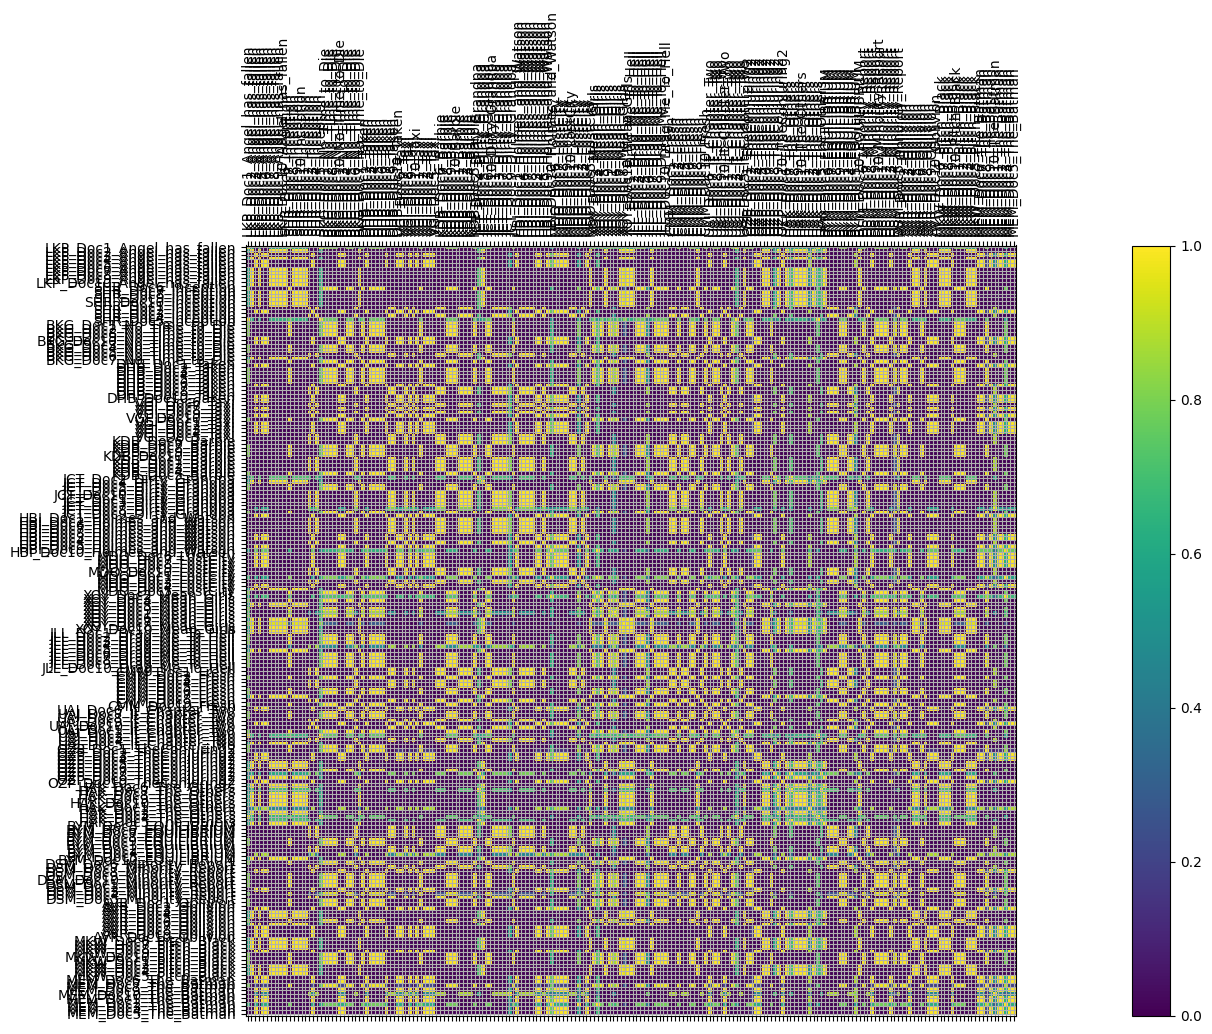

In [24]:
# BARRYC EXPERIMENTAL#1
#model2,dictionary2,index2,doctermmatrix2=create_gensim_lda_model(processed_text,number_of_topics,words,titles)
model2,dictionary2,index2,doctermmatrix2=create_gensim_lda_model(processed_text,number_of_topics, words)

for doc in processed_text:
    vec_bow2 = dictionary2.doc2bow(doc)
    vec2 = model2[vec_bow2]  # convert the query to embedded space
    sims2 = index2[vec2]  # perform a similarity query against the corpus
    #print(list(enumerate(sims2)))

fig, ax = plt.subplots(figsize=(30, 10))
cax = ax.matshow(index2, interpolation='nearest')
ax.grid(True)
plt.xticks(range(len(processed_text)), titles, rotation=90);
plt.yticks(range(len(processed_text)), titles);
fig.colorbar(cax)
plt.show()

### Compare LDA Model Coherence

In [25]:
topics = [i for i in range(2,21)]
coherence_values = []
for t in topics:
    #BARRYC EXPERIMENTAL#1
    # ldamodel,dictionary,index, matrix = create_gensim_lda_model(processed_text,t,10,titles)
    ldamodel,dictionary,index, matrix = create_gensim_lda_model(processed_text,t,10)


    coherence_model_lda = CoherenceModel(model=ldamodel, dictionary=dictionary, texts=processed_text, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)


coherence = {f"{i} topics 10 words": coherence_values[i-2] for i in topics}

print(coherence)

[(0, '0.003*"action" + 0.003*"story" + 0.003*"horror" + 0.003*"house" + 0.003*"first" + 0.003*"characters" + 0.002*"character" + 0.002*"school" + 0.002*"years" + 0.002*"still"'), (1, '0.004*"would" + 0.003*"barbie" + 0.003*"holmes" + 0.003*"world" + 0.003*"first" + 0.002*"story" + 0.002*"watson" + 0.002*"comedy" + 0.002*"action" + 0.002*"years"')]


[(0, '0.004*"house" + 0.003*"horror" + 0.003*"story" + 0.003*"characters" + 0.003*"could" + 0.003*"raimi" + 0.003*"character" + 0.003*"really" + 0.002*"first" + 0.002*"christine"'), (1, '0.005*"barbie" + 0.004*"would" + 0.003*"world" + 0.003*"holmes" + 0.003*"action" + 0.003*"first" + 0.002*"story" + 0.002*"years" + 0.002*"comedy" + 0.002*"steve"'), (2, '0.004*"batman" + 0.003*"action" + 0.003*"would" + 0.003*"story" + 0.003*"years" + 0.003*"first" + 0.003*"still" + 0.002*"people" + 0.002*"world" + 0.002*"character"')]


[(0, '0.004*"house" + 0.003*"character" + 0.003*"characters" + 0.003*"could" + 0.003*"grace" + 0.003*"people" + 0.002*"story" + 0.002*"fallen" + 0.002*"banning" + 0.002*"children"'), (1, '0.006*"barbie" + 0.004*"holmes" + 0.004*"would" + 0.003*"jason" + 0.003*"first" + 0.003*"comedy" + 0.003*"story" + 0.002*"watson" + 0.002*"character" + 0.002*"steve"'), (2, '0.005*"batman" + 0.004*"story" + 0.004*"would" + 0.003*"action" + 0.003*"years" + 0.003*"first" + 0.002*"still" + 0.002*"played" + 0.002*"holmes" + 0.002*"reeves"'), (3, '0.004*"action" + 0.003*"world" + 0.003*"horror" + 0.003*"women" + 0.003*"first" + 0.003*"girls" + 0.003*"really" + 0.003*"would" + 0.003*"story" + 0.003*"christine"')]


[(0, '0.004*"house" + 0.004*"character" + 0.003*"characters" + 0.003*"really" + 0.003*"banning" + 0.003*"fallen" + 0.003*"president" + 0.003*"people" + 0.003*"story" + 0.003*"grace"'), (1, '0.006*"barbie" + 0.005*"holmes" + 0.004*"would" + 0.003*"watson" + 0.003*"story" + 0.003*"first" + 0.003*"comedy" + 0.003*"jason" + 0.002*"could" + 0.002*"every"'), (2, '0.005*"batman" + 0.004*"would" + 0.004*"action" + 0.003*"story" + 0.003*"years" + 0.003*"still" + 0.002*"played" + 0.002*"first" + 0.002*"french" + 0.002*"great"'), (3, '0.005*"action" + 0.004*"world" + 0.003*"christine" + 0.003*"horror" + 0.003*"story" + 0.003*"years" + 0.003*"women" + 0.003*"first" + 0.003*"raimi" + 0.003*"still"'), (4, '0.006*"girls" + 0.005*"school" + 0.003*"batman" + 0.003*"janis" + 0.002*"fresh" + 0.002*"regina" + 0.002*"first" + 0.002*"young" + 0.002*"world" + 0.002*"plastics"')]


[(0, '0.005*"house" + 0.004*"character" + 0.003*"grace" + 0.003*"characters" + 0.003*"could" + 0.002*"always" + 0.002*"banning" + 0.002*"story" + 0.002*"director" + 0.002*"first"'), (1, '0.007*"barbie" + 0.007*"holmes" + 0.006*"would" + 0.004*"watson" + 0.003*"first" + 0.003*"comedy" + 0.003*"jason" + 0.003*"story" + 0.003*"loretta" + 0.003*"ferrell"'), (2, '0.006*"batman" + 0.004*"action" + 0.003*"played" + 0.003*"character" + 0.003*"would" + 0.003*"story" + 0.003*"years" + 0.003*"reeves" + 0.003*"great" + 0.002*"world"'), (3, '0.004*"action" + 0.004*"world" + 0.003*"christine" + 0.003*"years" + 0.003*"horror" + 0.003*"story" + 0.003*"women" + 0.003*"first" + 0.003*"could" + 0.003*"never"'), (4, '0.007*"girls" + 0.006*"school" + 0.005*"fresh" + 0.004*"steve" + 0.003*"batman" + 0.003*"dating" + 0.003*"janis" + 0.003*"first" + 0.003*"regina" + 0.003*"would"'), (5, '0.004*"action" + 0.003*"conjuring" + 0.003*"characters" + 0.003*"really" + 0.003*"story" + 0.003*"fallen" + 0.003*"house" +

[(0, '0.004*"school" + 0.004*"character" + 0.003*"inception" + 0.003*"banning" + 0.003*"first" + 0.003*"president" + 0.002*"could" + 0.002*"never" + 0.002*"characters" + 0.002*"played"'), (1, '0.007*"holmes" + 0.006*"barbie" + 0.005*"watson" + 0.004*"would" + 0.003*"jason" + 0.003*"comedy" + 0.003*"first" + 0.003*"story" + 0.003*"ferrell" + 0.003*"character"'), (2, '0.007*"batman" + 0.004*"would" + 0.004*"action" + 0.003*"played" + 0.003*"years" + 0.003*"loretta" + 0.003*"character" + 0.003*"reeves" + 0.003*"story" + 0.003*"world"'), (3, '0.005*"action" + 0.004*"world" + 0.004*"could" + 0.003*"story" + 0.003*"years" + 0.003*"women" + 0.003*"first" + 0.003*"never" + 0.003*"people" + 0.003*"still"'), (4, '0.006*"girls" + 0.005*"school" + 0.004*"batman" + 0.003*"fresh" + 0.003*"regina" + 0.003*"janis" + 0.003*"steve" + 0.003*"world" + 0.003*"comes" + 0.002*"first"'), (5, '0.004*"action" + 0.004*"fallen" + 0.003*"french" + 0.003*"really" + 0.003*"barbie" + 0.003*"people" + 0.003*"character

[(0, '0.004*"banning" + 0.004*"president" + 0.004*"character" + 0.003*"played" + 0.003*"house" + 0.003*"characters" + 0.003*"director" + 0.003*"first" + 0.002*"could" + 0.002*"story"'), (1, '0.009*"holmes" + 0.008*"barbie" + 0.006*"watson" + 0.005*"would" + 0.004*"ferrell" + 0.004*"comedy" + 0.004*"reilly" + 0.004*"sherlock" + 0.004*"first" + 0.003*"could"'), (2, '0.005*"batman" + 0.005*"action" + 0.004*"would" + 0.003*"years" + 0.003*"world" + 0.003*"story" + 0.003*"played" + 0.003*"character" + 0.003*"oblivion" + 0.003*"still"'), (3, '0.005*"action" + 0.004*"world" + 0.004*"years" + 0.003*"story" + 0.003*"first" + 0.003*"women" + 0.003*"could" + 0.003*"never" + 0.003*"people" + 0.002*"still"'), (4, '0.003*"fresh" + 0.003*"could" + 0.003*"place" + 0.002*"friend" + 0.002*"paris" + 0.002*"people" + 0.002*"women" + 0.002*"still" + 0.002*"going" + 0.002*"first"'), (5, '0.005*"action" + 0.004*"fallen" + 0.004*"really" + 0.004*"characters" + 0.003*"people" + 0.003*"would" + 0.003*"inception

[(0, '0.004*"banning" + 0.004*"president" + 0.004*"character" + 0.003*"house" + 0.003*"first" + 0.003*"another" + 0.003*"could" + 0.003*"played" + 0.003*"fallen" + 0.003*"franchise"'), (1, '0.008*"barbie" + 0.007*"holmes" + 0.005*"jason" + 0.005*"watson" + 0.004*"would" + 0.004*"comedy" + 0.003*"first" + 0.003*"story" + 0.003*"ferrell" + 0.003*"could"'), (2, '0.005*"action" + 0.004*"played" + 0.004*"batman" + 0.004*"would" + 0.003*"loretta" + 0.003*"world" + 0.003*"story" + 0.003*"holmes" + 0.003*"great" + 0.003*"earth"'), (3, '0.005*"action" + 0.004*"world" + 0.004*"people" + 0.003*"women" + 0.003*"years" + 0.003*"could" + 0.003*"story" + 0.003*"still" + 0.003*"barbie" + 0.003*"harper"'), (4, '0.005*"fresh" + 0.004*"batman" + 0.004*"steve" + 0.003*"could" + 0.003*"dating" + 0.003*"place" + 0.003*"women" + 0.003*"friend" + 0.003*"first" + 0.002*"paris"'), (5, '0.005*"fallen" + 0.005*"characters" + 0.004*"action" + 0.004*"people" + 0.004*"barbie" + 0.003*"still" + 0.003*"really" + 0.003

[(0, '0.004*"nolan" + 0.004*"house" + 0.004*"characters" + 0.003*"character" + 0.003*"inception" + 0.003*"grace" + 0.003*"could" + 0.003*"children" + 0.003*"never" + 0.003*"another"'), (1, '0.010*"holmes" + 0.009*"barbie" + 0.006*"watson" + 0.005*"would" + 0.004*"ferrell" + 0.004*"comedy" + 0.004*"sherlock" + 0.004*"reilly" + 0.004*"jason" + 0.003*"could"'), (2, '0.005*"action" + 0.004*"batman" + 0.004*"story" + 0.004*"earth" + 0.004*"oblivion" + 0.003*"would" + 0.003*"world" + 0.003*"cruise" + 0.003*"holmes" + 0.003*"great"'), (3, '0.004*"action" + 0.004*"world" + 0.004*"women" + 0.003*"story" + 0.003*"years" + 0.003*"first" + 0.003*"james" + 0.003*"craig" + 0.003*"horror" + 0.003*"harper"'), (4, '0.004*"batman" + 0.004*"fresh" + 0.003*"comes" + 0.003*"parents" + 0.003*"friend" + 0.003*"paris" + 0.003*"women" + 0.003*"people" + 0.003*"girls" + 0.003*"still"'), (5, '0.005*"barbie" + 0.004*"people" + 0.004*"characters" + 0.004*"really" + 0.004*"planet" + 0.003*"black" + 0.003*"pitch" + 

[(0, '0.004*"house" + 0.003*"president" + 0.003*"first" + 0.003*"another" + 0.003*"banning" + 0.003*"could" + 0.003*"grace" + 0.003*"nolan" + 0.003*"never" + 0.002*"character"'), (1, '0.009*"barbie" + 0.005*"jason" + 0.005*"holmes" + 0.004*"comedy" + 0.004*"watson" + 0.003*"would" + 0.003*"first" + 0.003*"could" + 0.003*"world" + 0.003*"story"'), (2, '0.006*"action" + 0.004*"oblivion" + 0.004*"earth" + 0.004*"would" + 0.004*"story" + 0.004*"neeson" + 0.003*"cruise" + 0.003*"great" + 0.003*"world" + 0.003*"planet"'), (3, '0.004*"action" + 0.004*"world" + 0.004*"women" + 0.004*"craig" + 0.003*"james" + 0.003*"story" + 0.003*"people" + 0.003*"first" + 0.003*"years" + 0.003*"horror"'), (4, '0.005*"batman" + 0.003*"paris" + 0.003*"friend" + 0.003*"first" + 0.003*"girls" + 0.003*"mitchell" + 0.003*"reeves" + 0.003*"women" + 0.003*"cruise" + 0.002*"could"'), (5, '0.005*"action" + 0.005*"really" + 0.005*"barbie" + 0.005*"characters" + 0.004*"people" + 0.004*"would" + 0.003*"still" + 0.003*"mak

[(0, '0.005*"house" + 0.004*"character" + 0.004*"banning" + 0.004*"fallen" + 0.003*"angel" + 0.003*"children" + 0.003*"conjuring" + 0.003*"story" + 0.003*"director" + 0.003*"grace"'), (1, '0.012*"barbie" + 0.006*"would" + 0.004*"jason" + 0.004*"first" + 0.003*"comedy" + 0.003*"daughter" + 0.003*"story" + 0.003*"holmes" + 0.003*"still" + 0.003*"never"'), (2, '0.007*"action" + 0.004*"holmes" + 0.004*"world" + 0.003*"fallen" + 0.003*"batman" + 0.003*"cruise" + 0.003*"great" + 0.003*"years" + 0.003*"story" + 0.003*"oblivion"'), (3, '0.005*"action" + 0.005*"world" + 0.005*"story" + 0.004*"women" + 0.004*"years" + 0.003*"harper" + 0.003*"would" + 0.003*"people" + 0.003*"first" + 0.003*"craig"'), (4, '0.004*"batman" + 0.003*"still" + 0.003*"paris" + 0.003*"friend" + 0.003*"fresh" + 0.003*"without" + 0.003*"going" + 0.003*"action" + 0.003*"girls" + 0.003*"parents"'), (5, '0.005*"really" + 0.004*"something" + 0.004*"makes" + 0.004*"would" + 0.004*"story" + 0.004*"characters" + 0.003*"action" + 

[(0, '0.005*"house" + 0.003*"character" + 0.003*"children" + 0.003*"story" + 0.003*"conjuring" + 0.003*"grace" + 0.003*"characters" + 0.003*"franchise" + 0.003*"horror" + 0.003*"never"'), (1, '0.011*"barbie" + 0.006*"jason" + 0.005*"would" + 0.004*"comedy" + 0.004*"first" + 0.003*"grandpa" + 0.003*"world" + 0.003*"holmes" + 0.003*"dirty" + 0.003*"watson"'), (2, '0.007*"action" + 0.004*"great" + 0.004*"world" + 0.003*"batman" + 0.003*"fallen" + 0.003*"oblivion" + 0.003*"first" + 0.003*"story" + 0.002*"neeson" + 0.002*"french"'), (3, '0.006*"action" + 0.005*"world" + 0.005*"women" + 0.004*"years" + 0.004*"story" + 0.004*"first" + 0.003*"barbie" + 0.003*"harper" + 0.003*"james" + 0.003*"still"'), (4, '0.006*"batman" + 0.004*"paris" + 0.003*"girls" + 0.003*"parents" + 0.003*"friend" + 0.003*"going" + 0.003*"reeves" + 0.003*"mitchell" + 0.003*"action" + 0.003*"without"'), (5, '0.005*"would" + 0.004*"really" + 0.004*"barbie" + 0.004*"story" + 0.004*"characters" + 0.004*"makes" + 0.003*"going

[(0, '0.006*"house" + 0.004*"children" + 0.004*"grace" + 0.003*"conjuring" + 0.003*"story" + 0.003*"really" + 0.003*"franchise" + 0.003*"horror" + 0.003*"another" + 0.003*"around"'), (1, '0.015*"barbie" + 0.004*"story" + 0.004*"robbie" + 0.003*"would" + 0.003*"first" + 0.003*"world" + 0.003*"holmes" + 0.003*"another" + 0.003*"gosling" + 0.003*"watson"'), (2, '0.007*"action" + 0.004*"great" + 0.004*"world" + 0.004*"fallen" + 0.003*"batman" + 0.003*"first" + 0.002*"years" + 0.002*"attempts" + 0.002*"neeson" + 0.002*"though"'), (3, '0.006*"women" + 0.005*"world" + 0.005*"action" + 0.004*"people" + 0.003*"barbie" + 0.003*"story" + 0.003*"years" + 0.003*"actually" + 0.003*"still" + 0.003*"would"'), (4, '0.007*"school" + 0.006*"batman" + 0.004*"regina" + 0.004*"janis" + 0.004*"girls" + 0.003*"still" + 0.003*"plastics" + 0.003*"parents" + 0.003*"cliques" + 0.003*"friend"'), (5, '0.004*"action" + 0.004*"would" + 0.004*"story" + 0.004*"makes" + 0.003*"barbie" + 0.003*"characters" + 0.003*"peopl

[(0, '0.006*"house" + 0.005*"banning" + 0.005*"president" + 0.004*"first" + 0.004*"children" + 0.004*"grace" + 0.003*"franchise" + 0.003*"character" + 0.003*"around" + 0.003*"story"'), (1, '0.009*"barbie" + 0.004*"first" + 0.004*"comedy" + 0.003*"story" + 0.003*"would" + 0.003*"years" + 0.003*"minutes" + 0.003*"another" + 0.003*"could" + 0.003*"whose"'), (2, '0.008*"action" + 0.005*"great" + 0.005*"batman" + 0.004*"world" + 0.004*"story" + 0.004*"reeves" + 0.004*"cruise" + 0.003*"fallen" + 0.003*"earth" + 0.003*"human"'), (3, '0.005*"action" + 0.004*"women" + 0.004*"world" + 0.003*"black" + 0.003*"people" + 0.003*"harper" + 0.003*"story" + 0.003*"chapter" + 0.003*"horror" + 0.003*"really"'), (4, '0.005*"school" + 0.005*"girls" + 0.003*"going" + 0.003*"comes" + 0.003*"spielberg" + 0.003*"friend" + 0.003*"still" + 0.003*"parents" + 0.003*"times" + 0.003*"place"'), (5, '0.005*"would" + 0.004*"really" + 0.004*"story" + 0.004*"makes" + 0.004*"characters" + 0.004*"people" + 0.003*"something"

[(0, '0.006*"fallen" + 0.005*"house" + 0.005*"conjuring" + 0.005*"banning" + 0.005*"angel" + 0.004*"director" + 0.004*"president" + 0.004*"story" + 0.004*"franchise" + 0.004*"london"'), (1, '0.008*"barbie" + 0.008*"jason" + 0.005*"comedy" + 0.005*"grandpa" + 0.004*"dirty" + 0.004*"holmes" + 0.004*"first" + 0.004*"world" + 0.004*"watson" + 0.003*"another"'), (2, '0.007*"action" + 0.004*"world" + 0.004*"great" + 0.004*"earth" + 0.004*"story" + 0.003*"fallen" + 0.003*"oblivion" + 0.003*"cruise" + 0.003*"planet" + 0.003*"batman"'), (3, '0.006*"action" + 0.005*"world" + 0.005*"women" + 0.004*"harper" + 0.004*"years" + 0.004*"story" + 0.003*"dream" + 0.003*"people" + 0.003*"would" + 0.003*"still"'), (4, '0.004*"paris" + 0.003*"girls" + 0.003*"friend" + 0.003*"women" + 0.003*"actually" + 0.003*"could" + 0.003*"going" + 0.003*"action" + 0.003*"cruise" + 0.003*"oblivion"'), (5, '0.005*"makes" + 0.004*"planet" + 0.004*"characters" + 0.003*"really" + 0.003*"black" + 0.003*"people" + 0.003*"world"

[(0, '0.005*"story" + 0.004*"conjuring" + 0.004*"house" + 0.003*"franchise" + 0.003*"thing" + 0.003*"first" + 0.003*"director" + 0.003*"screen" + 0.003*"character" + 0.003*"might"'), (1, '0.014*"barbie" + 0.009*"jason" + 0.005*"grandpa" + 0.004*"comedy" + 0.004*"dirty" + 0.003*"story" + 0.003*"robbie" + 0.003*"world" + 0.003*"grandson" + 0.003*"first"'), (2, '0.006*"action" + 0.005*"batman" + 0.004*"great" + 0.004*"story" + 0.003*"neeson" + 0.003*"would" + 0.003*"oblivion" + 0.003*"played" + 0.003*"world" + 0.002*"french"'), (3, '0.007*"action" + 0.006*"world" + 0.005*"women" + 0.004*"barbie" + 0.004*"story" + 0.004*"harper" + 0.004*"black" + 0.003*"people" + 0.003*"dream" + 0.003*"characters"'), (4, '0.007*"batman" + 0.004*"paris" + 0.003*"friend" + 0.003*"girls" + 0.003*"cruise" + 0.003*"reeves" + 0.003*"mitchell" + 0.003*"parents" + 0.003*"young" + 0.003*"within"'), (5, '0.006*"really" + 0.005*"action" + 0.005*"planet" + 0.004*"characters" + 0.004*"makes" + 0.003*"horror" + 0.003*"p

[(0, '0.008*"house" + 0.006*"children" + 0.006*"grace" + 0.004*"story" + 0.004*"woman" + 0.003*"franchise" + 0.003*"horror" + 0.003*"conjuring" + 0.003*"servants" + 0.003*"might"'), (1, '0.011*"barbie" + 0.003*"first" + 0.003*"robbie" + 0.003*"comedy" + 0.003*"world" + 0.003*"holmes" + 0.003*"never" + 0.003*"performances" + 0.003*"every" + 0.003*"watson"'), (2, '0.006*"action" + 0.004*"would" + 0.004*"story" + 0.003*"batman" + 0.003*"neeson" + 0.003*"human" + 0.003*"planet" + 0.003*"cruise" + 0.003*"years" + 0.003*"attempts"'), (3, '0.005*"action" + 0.005*"world" + 0.005*"women" + 0.004*"story" + 0.003*"people" + 0.003*"harper" + 0.003*"barbie" + 0.003*"craig" + 0.003*"jokes" + 0.003*"years"'), (4, '0.012*"girls" + 0.011*"school" + 0.008*"fresh" + 0.008*"steve" + 0.007*"regina" + 0.007*"dating" + 0.005*"parents" + 0.005*"friend" + 0.005*"cliques" + 0.005*"janis"'), (5, '0.005*"fallen" + 0.005*"action" + 0.005*"really" + 0.004*"planet" + 0.004*"black" + 0.003*"makes" + 0.003*"pitch" + 0

[(0, '0.009*"house" + 0.006*"grace" + 0.006*"children" + 0.004*"horror" + 0.003*"conjuring" + 0.003*"servants" + 0.003*"woman" + 0.003*"always" + 0.003*"story" + 0.003*"franchise"'), (1, '0.010*"barbie" + 0.007*"jason" + 0.005*"steve" + 0.005*"grandpa" + 0.005*"dirty" + 0.004*"comedy" + 0.004*"world" + 0.003*"robbie" + 0.003*"dating" + 0.003*"story"'), (2, '0.007*"action" + 0.005*"story" + 0.004*"batman" + 0.004*"great" + 0.004*"would" + 0.003*"years" + 0.003*"neeson" + 0.003*"world" + 0.003*"reeves" + 0.003*"holmes"'), (3, '0.009*"action" + 0.006*"world" + 0.006*"women" + 0.005*"harper" + 0.004*"black" + 0.004*"story" + 0.004*"people" + 0.004*"barbie" + 0.004*"cruise" + 0.003*"order"'), (4, '0.005*"paris" + 0.004*"friend" + 0.004*"girls" + 0.004*"batman" + 0.004*"cruise" + 0.003*"oblivion" + 0.003*"special" + 0.003*"daughter" + 0.003*"within" + 0.003*"family"'), (5, '0.005*"makes" + 0.004*"really" + 0.004*"world" + 0.004*"characters" + 0.004*"black" + 0.004*"character" + 0.003*"almost

[(0, '0.005*"story" + 0.005*"conjuring" + 0.004*"house" + 0.004*"cruise" + 0.003*"around" + 0.003*"another" + 0.003*"character" + 0.003*"could" + 0.003*"nolan" + 0.003*"along"'), (1, '0.011*"barbie" + 0.005*"jason" + 0.004*"world" + 0.004*"robbie" + 0.004*"grace" + 0.004*"dirty" + 0.004*"grandpa" + 0.003*"mills" + 0.003*"house" + 0.003*"another"'), (2, '0.009*"action" + 0.005*"world" + 0.005*"great" + 0.004*"fallen" + 0.004*"batman" + 0.004*"story" + 0.003*"oblivion" + 0.003*"years" + 0.003*"neeson" + 0.003*"human"'), (3, '0.007*"action" + 0.005*"world" + 0.004*"women" + 0.004*"harper" + 0.004*"story" + 0.004*"barbie" + 0.003*"horror" + 0.003*"woman" + 0.003*"years" + 0.003*"dream"'), (4, '0.010*"paris" + 0.006*"oblivion" + 0.005*"girls" + 0.005*"cruise" + 0.004*"could" + 0.004*"daughter" + 0.004*"laugh" + 0.004*"excia" + 0.004*"staying" + 0.004*"start"'), (5, '0.005*"makes" + 0.005*"would" + 0.005*"really" + 0.004*"planet" + 0.004*"black" + 0.004*"story" + 0.003*"pitch" + 0.003*"chara

[(0, '0.008*"house" + 0.006*"children" + 0.006*"grace" + 0.004*"story" + 0.004*"woman" + 0.003*"franchise" + 0.003*"horror" + 0.003*"conjuring" + 0.003*"servants" + 0.003*"might" + 0.003*"always" + 0.003*"despite" + 0.003*"another" + 0.003*"course" + 0.003*"james" + 0.003*"young" + 0.003*"amenabar" + 0.003*"christine" + 0.003*"thing" + 0.002*"enough"'), (1, '0.011*"barbie" + 0.003*"first" + 0.003*"robbie" + 0.003*"comedy" + 0.003*"world" + 0.003*"holmes" + 0.003*"never" + 0.003*"performances" + 0.003*"every" + 0.003*"watson" + 0.003*"another" + 0.003*"story" + 0.003*"loretta" + 0.003*"character" + 0.003*"gosling" + 0.003*"awful" + 0.003*"point" + 0.002*"would" + 0.002*"funny" + 0.002*"watch"'), (2, '0.006*"action" + 0.004*"would" + 0.004*"story" + 0.003*"batman" + 0.003*"neeson" + 0.003*"human" + 0.003*"planet" + 0.003*"cruise" + 0.003*"years" + 0.003*"attempts" + 0.003*"fallen" + 0.003*"world" + 0.003*"character" + 0.003*"taken" + 0.003*"little" + 0.003*"think" + 0.002*"earth" + 0.002

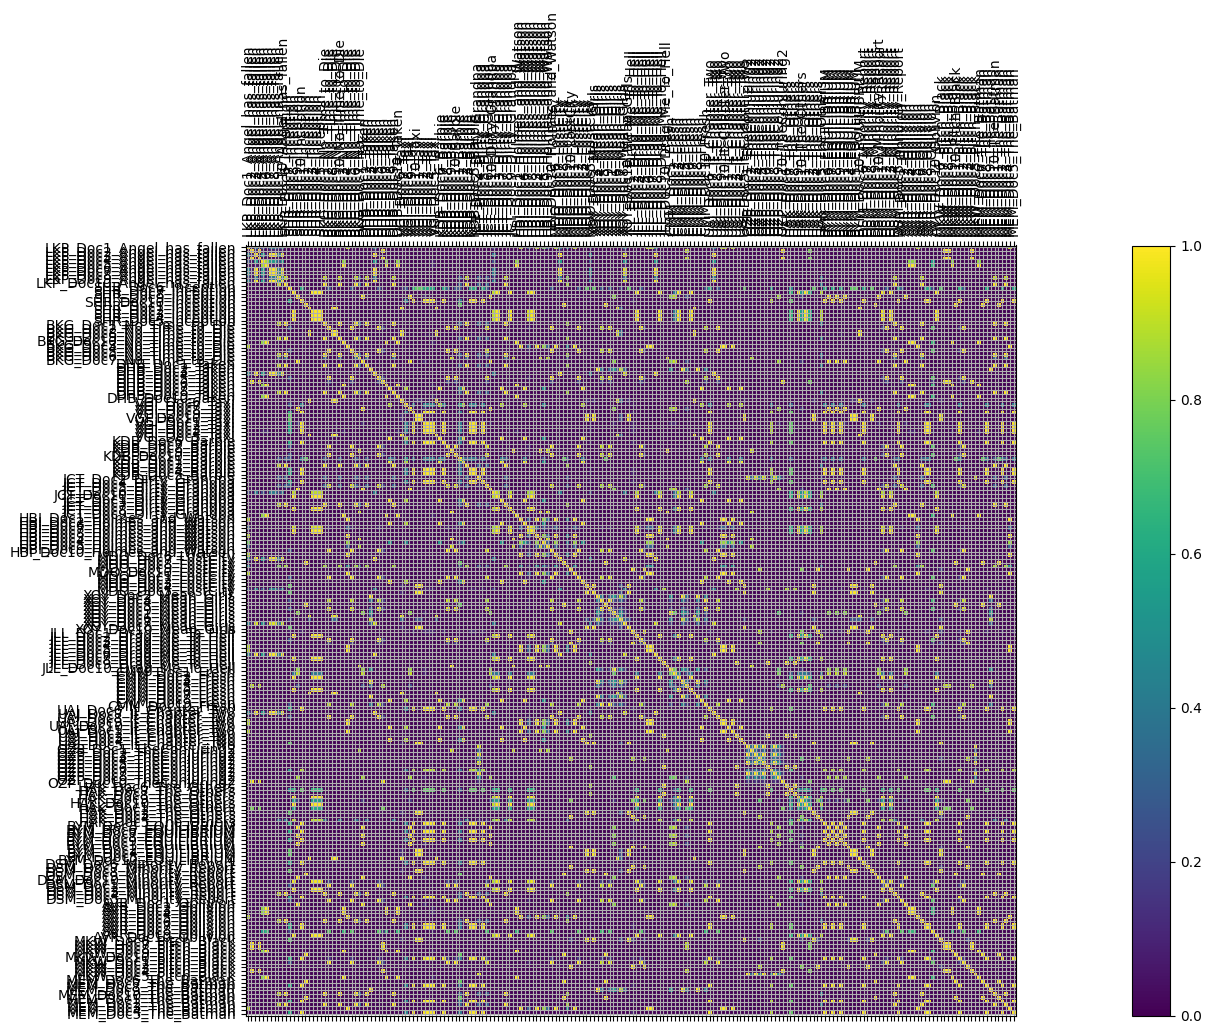

In [26]:
number_of_topics=18
words=20
#model2,dictionary2,index2,doctermmatrix2=create_gensim_lda_model(processed_text,number_of_topics,words,titles)
model2,dictionary2,index2,doctermmatrix2=create_gensim_lda_model(processed_text,number_of_topics, words)

for doc in processed_text:
    vec_bow2 = dictionary2.doc2bow(doc)
    vec2 = model2[vec_bow2]  # convert the query to embedded space
    sims2 = index2[vec2]  # perform a similarity query against the corpus
    #print(list(enumerate(sims2)))

fig, ax = plt.subplots(figsize=(30, 10))
cax = ax.matshow(index2, interpolation='nearest')
ax.grid(True)
plt.xticks(range(len(processed_text)), titles, rotation=90);
plt.yticks(range(len(processed_text)), titles);
fig.colorbar(cax)
plt.show()

[(0, '0.003*"action" + 0.003*"story" + 0.003*"horror" + 0.003*"house" + 0.003*"first" + 0.003*"characters" + 0.002*"character" + 0.002*"school" + 0.002*"years" + 0.002*"still" + 0.002*"would" + 0.002*"people" + 0.002*"could" + 0.002*"really" + 0.002*"director" + 0.002*"something" + 0.002*"world" + 0.002*"fallen" + 0.002*"girls" + 0.002*"raimi"'), (1, '0.004*"would" + 0.003*"barbie" + 0.003*"holmes" + 0.003*"world" + 0.003*"first" + 0.002*"story" + 0.002*"watson" + 0.002*"comedy" + 0.002*"action" + 0.002*"years" + 0.002*"could" + 0.002*"character" + 0.002*"still" + 0.002*"never" + 0.002*"women" + 0.002*"actually" + 0.002*"characters" + 0.002*"played" + 0.002*"craig" + 0.002*"batman"')]


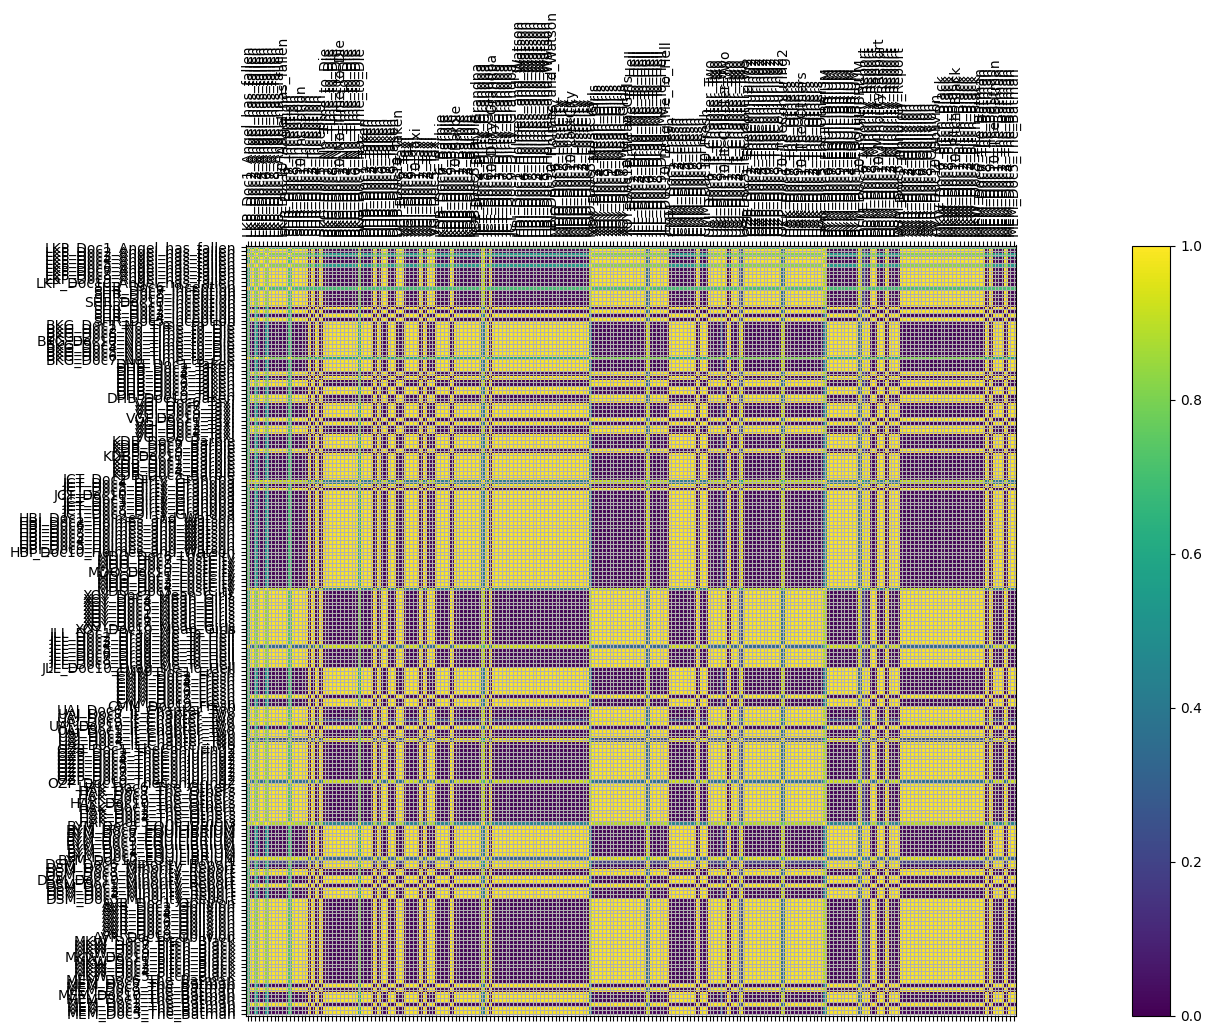

In [27]:
number_of_topics=2
words=20
#model2,dictionary2,index2,doctermmatrix2=create_gensim_lda_model(processed_text,number_of_topics,words,titles)
model2,dictionary2,index2,doctermmatrix2=create_gensim_lda_model(processed_text,number_of_topics, words)

for doc in processed_text:
    vec_bow2 = dictionary2.doc2bow(doc)
    vec2 = model2[vec_bow2]  # convert the query to embedded space
    sims2 = index2[vec2]  # perform a similarity query against the corpus
    #print(list(enumerate(sims2)))

fig, ax = plt.subplots(figsize=(30, 10))
cax = ax.matshow(index2, interpolation='nearest')
ax.grid(True)
plt.xticks(range(len(processed_text)), titles, rotation=90);
plt.yticks(range(len(processed_text)), titles);
fig.colorbar(cax)
plt.show()

&nbsp;